# Scripts utilizados

1. Control de calidad inicial: auto_firstcheck.sh
Este script ejecuta FastQ Screen para realizar un tamizaje inicial de las muestras crudas. Su función principal es detectar posibles contaminaciones mediante el mapeo de un subconjunto de lecturas contra múltiples genomas de referencia, permitiendo verificar la pureza de la librería antes del procesamiento.

In [ ]:
#!/usr/bin/env bash
set -euo pipefail

# --- Conda ---
source /usr/local/miniconda3/etc/profile.d/conda.sh
conda activate RNAseq   # ajusta si tu env tiene otro nombre

# --- Configuración ---
CONF="/home/gbernal/run/progeno_final/data/fastq_screen.conf"
FASTQ_DIR="/home/gbernal/data/proyecto/fastq"
OUTDIR="/home/gbernal/run/progeno_final/fastq_screen"

SAMPLES=(WT1 WT2 WT3 WT4 KO1 KO2 KO3)

THREADS=2
SUBSET=100000

mkdir -p "$OUTDIR"

echo "=== FastQ Screen iniciado ==="
echo "Muestras: ${SAMPLES[*]}"
echo "Threads: $THREADS | Subset: $SUBSET"
echo "----------------------------------------"

for S in "${SAMPLES[@]}"; do
  R1="${FASTQ_DIR}/${S}_R1.fastq"
  R2="${FASTQ_DIR}/${S}_R2.fastq"

  echo ">>> [$S] Ejecutando FastQ Screen"

  fastq_screen \
    --conf "$CONF" \
    --outdir "$OUTDIR" \
    --paired \
    --threads "$THREADS" \
    --subset "$SUBSET" \
    "$R1" "$R2" \
    &> "${OUTDIR}/${S}_fastq_screen.log"

  echo ">>> [$S] OK"
  echo "----------------------------------------"
done

echo "=== FastQ Screen finalizado ==="
conda deactivate

2. Preprocesamiento y limpieza: auto_cutadapt_fqc.sh
Script encargado de la remoción de adaptadores y el filtrado por calidad utilizando Cutadapt. Aplica parámetros de recorte de colas poli A, eliminación de Ns y filtrado de lecturas cortas. Al finalizar el proceso de limpieza, el script ejecuta automáticamente FastQC para comparar la calidad de las lecturas procesadas frente a las originales.

In [ ]:
#!/usr/bin/env bash
set -euo pipefail

#--- Activacion de ambiente miniconda ---
source /usr/local/miniconda3/etc/profile.d/conda.sh
conda activate RNAseq

# ---- Config ----
adapter="adapters.fa"
FASTQ_DIR="../../../data/proyecto/fastq"
IDS=(WT1 WT2 WT3 WT4 KO1 KO2 KO3)
fastqc_out="qualityctrl/"

# ---- Chequeos iniciales ----
if [[ ! -f "$adapter" ]]; then
  echo "ERROR: No encuentro el archivo de adaptadores: $adapter"
  exit 1
fi

if [[ ! -d "$FASTQ_DIR" ]]; then
  echo "ERROR: No encuentro el directorio de FASTQ: $FASTQ_DIR"
  exit 1
fi

echo "Procesando IDs: ${IDS[*]}"
echo "Adaptadores: $adapter"
echo "FASTQ_DIR: $FASTQ_DIR"
echo "--------------------------------------------------------"

# ---- Loop automático por cada muestra ----
for ID1 in "${IDS[@]}"; do
  in1="${FASTQ_DIR}/${ID1}_R1.fastq"
  in2="${FASTQ_DIR}/${ID1}_R2.fastq"

  echo ">>> [$ID1] Iniciando..."

  # Verificar entradas
  if [[ ! -f "$in1" || ! -f "$in2" ]]; then
    echo ">>> [$ID1] ERROR: faltan archivos de entrada"
    [[ ! -f "$in1" ]] && echo "    - Falta: $in1"
    [[ ! -f "$in2" ]] && echo "    - Falta: $in2"
    echo ">>> [$ID1] Saltando esta muestra y continuando..."
    echo "--------------------------------------------------------"
    continue
  fi

  # Ejecutar cutadapt
  cutadapt -a "file:$adapter" -A "file:$adapter" -g "file:$adapter" -G "file:$adapter" --action trim \
    -q 30 -Q 30 --poly-a --trim-n --pair-filter=any --minimum-length 50 \
    -o "${ID1}_R1_out.fastq" -p "${ID1}_R2_out.fastq" \
    "$in1" "$in2" > "report${ID1}.txt"

  echo ">>> [$ID1] OK: ${ID1}_R1_out.fastq, ${ID1}_R2_out.fastq | report${ID1}.txt"
  echo "--------------------------------------------------------"
  echo "Revision de calidad en proceso"

  # Ejecutar fastqc, doble ejecución (R1 y R2)
  fastqc "${ID1}_R1_out.fastq" -o "${fastqc_out}"
  fastqc "${ID1}_R2_out.fastq" -o "${fastqc_out}" 
  
  echo "Archivos .html los puedes revisar en ${fastqc_out}" 
done

echo "Listo: se procesaron todas las muestras."
conda deactivate

adapters.fa
>SMARTseq_TSO_PolyG_3prime
AAGCAGTGGTATCAACGCAGAGTACATGGGG
>SMARTseq_Primer_IIA
AAGCAGTGGTATCAACGCAGAGTAC
>Nextera_Transposase_R1
TCGTCGGCAGCGTCAGATGTGTATAAGAGACAG
>Nextera_Transposase_R2
GTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG
>Nextera_Adapter_Trimming
CTGTCTCTTATACACATCT
>Nextera_P5_i5_Structure
AATGATACGGCGACCACCGAGATCTACACNNNNNNNNTCGTCGGCAGCGTC
>Nextera_P7_i7_Structure
CAAGCAGAAGACGGCATACGAGATNNNNNNNNGTCTCGTGGGCTCGG
>PolyG_Contamination
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

3. Alineamiento genómico: auto_aln.sh
Ejecuta el alineamiento de las lecturas procesadas al genoma de referencia de Mus musculus utilizando Hisat2. El script está configurado para considerar sitios de empalme (splice sites) conocidos, lo que optimiza la precisión del mapeo en datos de RNA-seq. Genera archivos en formato SAM y reportes individuales de alineamiento por muestra.

In [ ]:
#!/usr/bin/env bash
set -euo pipefail

#--- Activacion de ambiente miniconda ---
source /usr/local/miniconda3/etc/profile.d/conda.sh
conda activate Hisat2

# ---- Config ----
base_dir="/home/gbernal/run/progeno_final"
IDS=(WT1 WT2 WT3 WT4 KO1 KO2 KO3)
output="${base_dir}/alignment"

echo "--------------------------------------------------------"

# ---- Loop automático por cada muestra ----
for ID1 in "${IDS[@]}"; do
    echo --------------
    echo "Ejecutando HiSat2 con ID1: $IDS"

  # Ejecutar Hisat2
    hisat2 -x "${base_dir}/data/Mus_musculus.GRCm39.dna.primary_assembly" \
    -1 "${base_dir}/preprocessing/${ID1}_R1_out.fastq" \
    -2 "${base_dir}/preprocessing/${ID1}_R2_out.fastq" -S "mapped_${ID1}.sam" -q \
    --known-splicesite-infile "${base_dir}/data/Mus_musculus_GRCm39.107.ss" \
    &> "${output}/report${ID1}.txt"

    if [ $? -eq 0 ]; then
	echo "Reporte generado: report${ID1}.txt"
    else
	echo "Error. El comando falló en esta iteración"
fi

done

conda deactivate

4. Procesamiento de alineamientos: auto_sort_reports.sh
Este script utiliza Samtools para la manipulación de los archivos de alineamiento. Realiza la conversión de formato SAM a BAM, ordena las lecturas por posición genómica y genera reportes de estadísticas de mapeo (flagstat). Es un paso esencial para estructurar los datos antes del análisis de calidad post-mapeo y el conteo.

In [ ]:
#!/usr/bin/env bash
set -euo pipefail

#--- Activacion de ambiente miniconda ---
source /usr/local/miniconda3/etc/profile.d/conda.sh
conda activate samtools

# Sorting and report generation from alignment files
conditions=("WT1" "WT2" "WT3" "WT4" "KO1" "KO2" "KO3")
base_route="/home/gbernal/run/progeno_final/alignment"

echo "--- Ejecución de conversion inicial ---"

for condition in "${conditions[@]}"; do
    samtools sort "${base_route}/mapped_${condition}.sam" -o "sorted/mapped_sort_${condition}.bam"
    samtools flagstat "sorted/mapped_sort_${condition}.bam" > "stats/report${condition}.txt"

    echo "--- Comando finalizado para ${condition} ---"

done
echo "--- Comandos ejecutados con éxito ---"
conda deactivate

5. Control de calidad del alineamiento: auto_rseqc.sh
Implementa herramientas de la suite RSeQC para evaluar la calidad del mapeo. Incluye la inferencia de la naturaleza de la librería (strandedness), la distribución de lecturas sobre características genómicas y la cobertura de los cuerpos génicos (gene body coverage). Estos métricas aseguran que no existan sesgos técnicos significativos en la distribución de las lecturas mapeadas.

In [ ]:
#!/usr/bin/env bash
set -euo pipefail

source /usr/local/miniconda3/etc/profile.d/conda.sh
conda activate samtools


SORTED_DIR="sorted/"
BED="/home/gbernal/run/progeno_final/data/mouse/Mus_musculus.GRCm39.107.bed"
OUTDIR="rseqc/"

echo "=== 0) Indexando BAMs (si falta el .bai) en: ${SORTED_DIR} ==="

# Toma todas las condiciones desde los BAM ordenados
mapfile -t conditions < <(ls -1 "${SORTED_DIR}"/mapped_sort_*.bam 2>/dev/null \
  | sed -E 's|.*/mapped_sort_(.+)\.bam|\1|' \
  | sort -u)

# Si no hay nada, corta
if ((${#conditions[@]}==0)); then
  echo "[ERROR] No se encontraron BAMs tipo ${SORTED_DIR}/mapped_sort_*.bam" >&2
  exit 1
fi

# Bloque de indexación: si ya existen índices para todos, lo salta automáticamente
for condition in "${conditions[@]}"; do
  BAM="${SORTED_DIR}/mapped_sort_${condition}.bam"
  BAI="${BAM}.bai"
  [[ -f "${BAI}" ]] || samtools index "${BAM}"
done

conda deactivate
conda activate htseq-count
echo "=== 1) RSeQC por muestra: infer_experiment, read_distribution, junction_annotation ==="

for condition in "${conditions[@]}"; do
  echo "-> ${condition}"
  BAM="${SORTED_DIR}/mapped_sort_${condition}.bam"
  SOUT="${OUTDIR}/${condition}"
  mkdir -p "${SOUT}"

  infer_experiment.py -i "${BAM}" -r "${BED}" \
    > "${SOUT}/infer_experiment.txt" 2> "${SOUT}/infer_experiment.log"

  read_distribution.py -i "${BAM}" -r "${BED}" \
    > "${SOUT}/read_distribution.txt" 2> "${SOUT}/read_distribution.log"

  junction_annotation.py -i "${BAM}" -r "${BED}" -o "${SOUT}/junction_annotation" \
    > "${SOUT}/junction_annotation.log" 2>&1
done

echo "=== 2) geneBody_coverage.py (manteniendo tu estructura unified) ==="

# Mantener tu estructura: lista explícita de BAMs, salida unificada
# Nota: aquí se usa 1 BAM por condición. Si quieres repetir BAMs (no recomendado), cámbialo abajo.
BAM_LIST=()
for condition in "${conditions[@]}"; do
  BAM_LIST+=("${SORTED_DIR}/mapped_sort_${condition}.bam")
done

echo "-> Procesando geneBody_coverage.py para: ${conditions[*]}"
geneBody_coverage.py \
  -i "$(IFS=,; echo "${BAM_LIST[*]}")" \
  -r "${BED}" \
  -o "${OUTDIR}/genecoverage_unified" \
  > "${OUTDIR}/genebody_unified.log" 2>&1

echo "Listo. Resultados en: ${OUTDIR}/"
conda deactivate

6. Cuantificación de expresión: auto_conteo.sh
Script dedicado a la generación de la matriz de conteos utilizando htseq-count. El proceso se realiza de manera paralela para optimizar el tiempo de ejecución, asignando lecturas a genes específicos según las coordenadas definidas en el archivo de anotación GTF del ratón. El resultado es un archivo de texto por muestra con el número de lecturas asignadas a cada identificador genético.

In [ ]:
#!/usr/bin/env bash
set -euo pipefail

# ------------------------------------------------------------
# Conteo con htseq-count (paralelo por muestras)
# Asignación automática de CPUs dentro del script
# ------------------------------------------------------------

# --- Activación conda ---
source /usr/local/miniconda3/etc/profile.d/conda.sh
conda activate htseq-count

# Paths
BAM_DIR="/home/gbernal/run/progeno_final/alignment/sorted"
GTF="/home/gbernal/run/progeno_final/data/mouse/Mus_musculus.GRCm39.107.gtf"
OUT_DIR="/home/gbernal/run/progeno_final/conteo"

mkdir -p "${OUT_DIR}"

# ------------------------------------------------------------
# Asignación automática de CPUs
# ------------------------------------------------------------

TOTAL_CPUS=$(nproc)

# Usar solo cores físicos (~ mitad de los hilos lógicos)
# y dejar margen de seguridad para el sistema
JOBS=$(( TOTAL_CPUS / 4 ))

# Límites razonables
(( JOBS < 2 )) && JOBS=2
(( JOBS > 8 )) && JOBS=8

echo "[INFO] CPUs visibles       : ${TOTAL_CPUS}"
echo "[INFO] htseq-count en paralelo: ${JOBS}"

# ------------------------------------------------------------
# Condiciones
# ------------------------------------------------------------

conditions=("WT1" "WT2" "WT3" "WT4" "KO1" "KO2" "KO3")

run_one () {
  local condition="$1"
  local bam="${BAM_DIR}/mapped_sortname_${condition}.bam"
  local out="${OUT_DIR}/counts_${condition}.txt"
  local log="${OUT_DIR}/counts_${condition}.log"

  echo "[START] ${condition}"
  htseq-count \
    --stranded="no" \
    --idattr="gene_id" \
    "${bam}" "${GTF}" \
    > "${out}" 2> "${log}"
  echo "[DONE]  ${condition}"
}

export -f run_one
export BAM_DIR GTF OUT_DIR

# ------------------------------------------------------------
# Ejecución paralela
# ------------------------------------------------------------

if command -v parallel >/dev/null 2>&1; then
  parallel -j "${JOBS}" run_one ::: "${conditions[@]}"
else
  printf "%s\n" "${conditions[@]}" \
    | xargs -n1 -P "${JOBS}" -I{} bash -lc 'run_one "$@"' _ {}
fi

conda deactivate
echo "Conteo finalizado."

7. Análisis de expresión diferencial: DESeq2_script.R
Script final ejecutado en R para el análisis estadístico de los datos. Realiza la carga de los conteos, define la condición basal (Wild-type), normaliza los datos y ejecuta las pruebas estadísticas para identificar genes diferencialmente expresados. Además, genera transformaciones de datos (VSD) para visualizaciones y gráficos de diagnóstico como el MA plot para evaluar la magnitud de los cambios transcripcionales

In [ ]:
setwd('/home/gbernal/run/progeno_final/diffexp')


library( "DESeq2" )
#version 1.6.1

#desig metadata
metadata <- read.delim(file="/home/gbernal/run/progeno_final/diffexp/metadata.txt", header=TRUE)   

#create a count data set readabable by DESeq
ddsHTseq <- DESeqDataSetFromHTSeqCount(metadata, "/home/gbernal/run/progeno_final/conteo", design=~ Condition)

# define base level: logFC is the expected comparison agains the base level
ddsHTseq$Condition <- relevel(ddsHTseq$Condition, 'Wild-type')

#DE test
ddsHTseq <- DESeq(ddsHTseq)
#to visualized the results od the DE test (note that alpha value is set to 0.1 by default)
res <- results(ddsHTseq, cooksCutoff=FALSE )
write.table(res, file="DEtest.txt")

#order genes by adj p value
resOrdered <- res[order(res$padj), ]
head(resOrdered)
write.table(resOrdered, file="resOrdered.txt")


#obtain the normalized count
Normalized_count <- counts(ddsHTseq, normalized=TRUE)
write.table(Normalized_count, file="Normalized_count.txt")
raw_count <- counts(ddsHTseq, normalized=FALSE)
write.table(raw_count, file="raw_count.txt")
sizeFactors( ddsHTseq )

#summary of the results
summary(res)
#infomation about the columns on results
mcols(res)$description

#visualization by MAplot
pdf(file="plot_MAplot.pdf")
plotMA(resOrdered, main='Wild-type vs Knockout', ylim=c(-15,15))
dev.off()


#extraction transformed data:VSD
vsd <- varianceStabilizingTransformation(ddsHTseq)
vsd_transformation<-assay(vsd)
write.table(vsd_transformation, file="vsd_transformation.txt")


# Gráficos

fastq_screen: software para evaluar origen y contaminación de las lecturas de secuenciación

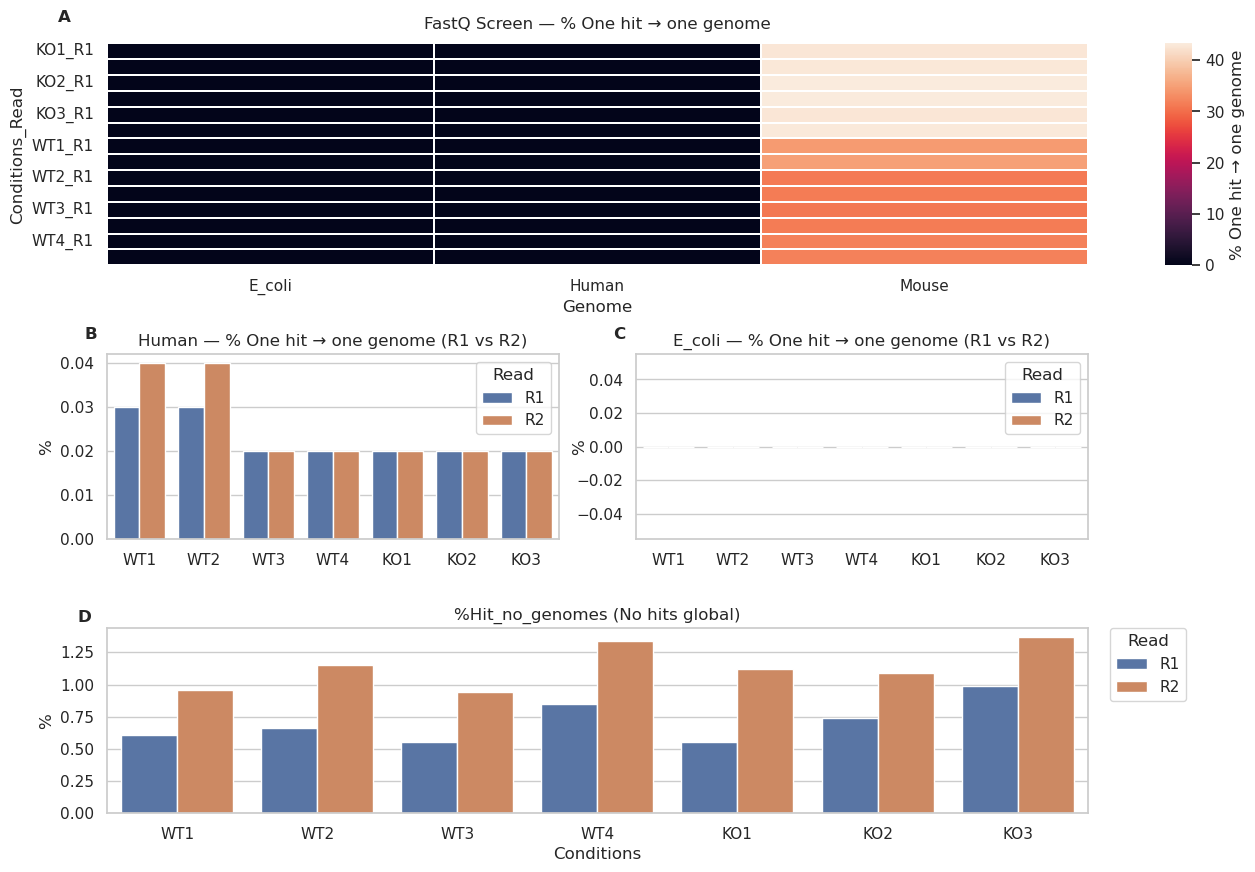

In [ ]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec


def parse_fastq_screen_txt(txt_path: Path) -> tuple[pd.DataFrame, float]:
    """
    Lee un archivo *_screen.txt de FastQ Screen y retorna:
      - df con filas por Genome y columnas de % (float)
      - hit_no_genomes (float) si existe, si no NaN
    """
    lines = txt_path.read_text().splitlines()

    # Encuentra el header de la tabla
    header_idx = None
    for i, line in enumerate(lines):
        if line.startswith("Genome\t#Reads_processed"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"No encuentro header de tabla en: {txt_path}")

    header = lines[header_idx].split("\t")
    table_lines = []
    for j in range(header_idx + 1, len(lines)):
        if not lines[j].strip():
            break
        if lines[j].startswith("%Hit_no_genomes:"):
            break
        table_lines.append(lines[j].split("\t"))

    df = pd.DataFrame(table_lines, columns=header)

    # Convierte columnas % a float
    pct_cols = [c for c in df.columns if c.startswith("%")]
    for c in pct_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Extrae %Hit_no_genomes
    hit_no_genomes = float("nan")
    for line in lines:
        if line.startswith("%Hit_no_genomes:"):
            hit_no_genomes = float(line.split(":")[1].strip())
            break

    return df, hit_no_genomes


def sample_read_from_filename(path: Path) -> tuple[str, str]:
    """
    Espera nombres como WT1_R1_screen.txt, KO3_R2_screen.txt, etc.
    Retorna (sample, read) = ("WT1", "R1")
    """
    m = re.match(r"^(WT\d+|KO\d+)_(R1|R2)_screen\.txt$", path.name)
    if not m:
        raise ValueError(f"Nombre inesperado: {path.name} (esperado: WT1_R1_screen.txt, etc.)")
    return m.group(1), m.group(2)


# === Carga de todos los .txt ===
def load_folder(folder: str | Path) -> pd.DataFrame:
    folder = Path(folder)
    files = sorted(folder.glob("*_screen.txt"))
    if not files:
        raise FileNotFoundError(f"No encontré *_screen.txt en: {folder}")

    records = []
    hit_no_genomes_map = []

    for f in files:
        sample, read = sample_read_from_filename(f)
        df, hit_no_genomes = parse_fastq_screen_txt(f)

        # Guardamos %Hit_no_genomes como una pseudo-fila (para barplot)
        hit_no_genomes_map.append(
            {"sample": sample, "read": read, "metric": "%Hit_no_genomes", "value": hit_no_genomes}
        )

        # Normalizamos estructura a tidy
        for _, row in df.iterrows():
            genome = row["Genome"]
            # Métricas clave (todas están en el .txt)
            for metric in [
                "%Unmapped",
                "%One_hit_one_genome",
                "%Multiple_hits_one_genome",
                "%One_hit_multiple_genomes",
                "%Multiple_hits_multiple_genomes",
            ]:
                records.append(
                    {
                        "sample": sample,
                        "read": read,
                        "genome": genome,
                        "metric": metric,
                        "value": float(row.get(metric, float("nan"))),
                    }
                )

    tidy = pd.DataFrame(records)
    hit_no = pd.DataFrame(hit_no_genomes_map)

    # Unimos en un solo DF "tidy" (hit_no_genomes no tiene genome)
    combined = pd.concat([tidy, hit_no], ignore_index=True)

    # Orden de muestras fijo (lo que pediste)
    sample_order = ["WT1", "WT2", "WT3", "WT4", "KO1", "KO2", "KO3"]
    combined["sample"] = pd.Categorical(combined["sample"], categories=sample_order, ordered=True)

    # Orden de reads
    combined["read"] = pd.Categorical(combined["read"], categories=["R1", "R2"], ordered=True)

    return combined


# -------------------------
# 3) Plot unificado
# -------------------------
def plot_unified_dashboard(df: pd.DataFrame, out_png: str | None = None) -> None:
    sns.set_theme(style="whitegrid")

    # --- Heatmap: %One_hit_one_genome por genoma y muestra/read ---
    heat = df[(df["metric"] == "%One_hit_one_genome") & (df["genome"].notna())].copy()
    # index = sample_read, columns = genome
    heat["sample_read"] = heat["sample"].astype(str) + "_" + heat["read"].astype(str)
    heat_pivot = heat.pivot_table(index="sample_read", columns="genome", values="value", aggfunc="mean")

    # --- Barplot: Human unique (mejor indicador de contaminación humana real) ---
    human_unique = df[(df["metric"] == "%One_hit_one_genome") & (df["genome"] == "Human")].copy()

    # --- Barplot: E. coli unique ---
    ecoli_unique = df[(df["metric"] == "%One_hit_one_genome") & (df["genome"] == "E_coli")].copy()

    # --- Barplot: %Hit_no_genomes (No hits global) ---
    no_hits = df[df["metric"] == "%Hit_no_genomes"].copy()

    fig = plt.figure(figsize=(14, 10))

    gs = GridSpec(
        3, 3,
        figure=fig,
        height_ratios=[1.2, 1.0, 1.0],
        width_ratios=[1, 1, 0.06],
        hspace=0.45,
        wspace=0.25
        )

    # (A) Heatmap
    ax1 = fig.add_subplot(gs[0, :2])
    cax = fig.add_subplot(gs[0, 2])
    sns.heatmap(
        heat_pivot,
        ax=ax1,
        cbar=True,
        cbar_ax=cax,
        robust=True,
        fmt=".1f",
        linewidths=0.1,
        linecolor="white",
        cbar_kws={"label": "% One hit → one genome"},
    )
    ax1.set_title("FastQ Screen — % One hit → one genome", fontsize=12, pad=10,)
    ax1.text(-0.05, 1.15, "A", transform=ax1.transAxes, 
            ha="left", va="top", fontsize=12, fontweight="bold")
    ax1.set_xlabel("Genome")
    ax1.set_ylabel("Conditions_Read")

    # (B) Human unique
    ax2 = fig.add_subplot(gs[1, 0])
    sns.barplot(
        data=human_unique,
        x="sample",
        y="value",
        hue="read",
        ax=ax2,
        errorbar=None,
    )
    ax2.set_title("Human — % One hit → one genome (R1 vs R2)")
    ax2.text(-0.05, 1.15, "B", transform=ax2.transAxes, 
            ha="left", va="top", fontsize=12, fontweight="bold")
    ax2.set_xlabel("")
    ax2.set_ylabel("%")
    ax2.legend(title="Read", loc="upper right")

    # (C) E. coli unique
    ax3 = fig.add_subplot(gs[1, 1])
    sns.barplot(
        data=ecoli_unique,
        x="sample",
        y="value",
        hue="read",
        ax=ax3,
        errorbar=None,
    )
    ax3.set_title("E_coli — % One hit → one genome (R1 vs R2)")
    ax3.text(-0.05, 1.15, "C", transform=ax3.transAxes, 
            ha="left", va="top", fontsize=12, fontweight="bold")
    ax3.set_xlabel("")
    ax3.set_ylabel("%", labelpad=-8)
    ax3.legend(title="Read", loc="upper right")

    # (D) No hits
    ax4 = fig.add_subplot(gs[2, :2])
    sns.barplot(
        data=no_hits,
        x="sample",
        y="value",
        hue="read",
        ax=ax4,
        errorbar=None,
    )
    ax4.set_title("%Hit_no_genomes (No hits global)")
    ax4.text(-0.03, 1.1, "D", transform=ax4.transAxes, 
            ha="left", va="top", fontsize=12, fontweight="bold")
    ax4.set_xlabel("Conditions")
    ax4.set_ylabel("%")
    ax4.legend(title="Read", loc="upper right",
                bbox_to_anchor=(1.1, 1.0), borderaxespad=0.0)

    if out_png:
        plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    # Carpeta donde están los *_screen.txt (ajusta)
    SCREEN_DIR = "/home/gonza/bioinfotest/run/progeno_final/fastq_screen"

    df = load_folder(SCREEN_DIR)
    plot_unified_dashboard(df, out_png="/home/gonza/bioinfotest/run/progeno_final/figures/fastq_screen_unificado.png")


#### Análisis de expresión diferencial (DIFF_EXP analysis)

1. Se extrajeron los ENSEMBL IDS de todos los genes expresados en el archivo DEtest.txt (DIFF_EXP analysis)

In [2]:
import os 
# === Input ====
DE_PATH   = "/home/gonza/bioinfotest/run/progeno_final/diffexp/DEtest.txt"
VST_PATH  = "/home/gonza/bioinfotest/run/progeno_final/diffexp/vsd_transformation.txt"
META_PATH = "/home/gonza/bioinfotest/run/progeno_final/diffexp/metadata.txt"
GENE_MAP_CSV = "/home/gonza/bioinfotest/run/progeno_final/diffexp/gene_name.txt" 

OUTDIR = "/home/gonza/bioinfotest/run/progeno_final/figures"
os.makedirs(OUTDIR, exist_ok=True)

PADJ_THR = 0.05
LFC_THR  = 1.0
TOP_LABELS = 14
TOP_HEATMAP = 50
TOP_PCA_VAR = 2000
DPI = 600

In [3]:
import pandas as pd

# ================= INPUT =================
OUT_ALL = "/home/gonza/bioinfotest/run/progeno_final/diffexp/genes_all_ensembl.txt"
OUT_SIG = "/home/gonza/bioinfotest/run/progeno_final/diffexp/genes_padj_lt_0.05_ensembl.txt"

# ================= LOAD =================
de = pd.read_csv(DE_PATH, sep=r"\s+", engine="python", quotechar='"')
de.columns = [c.strip('"') for c in de.columns]

# En DESeq2, el índice suele ser el Ensembl ID
de.index = de.index.astype(str).str.strip('"')

# Asegurar padj numérico
de["padj"] = pd.to_numeric(de["padj"], errors="coerce")

# ================= 1) TODOS los genes evaluados =================
# (genes con padj calculado, es decir, testeados por DESeq2)
all_genes = (
    de.dropna(subset=["padj"])
      .index
      .drop_duplicates()
      .sort_values()
)

pd.Series(all_genes).to_csv(OUT_ALL, index=False, header=False)

# ================= 2) Genes con padj < 0.05 =================
sig_genes = (
    de.loc[de["padj"] < PADJ_THR]
      .index
      .drop_duplicates()
      .sort_values()
)

pd.Series(sig_genes).to_csv(OUT_SIG, index=False, header=False)

# ================= OUTPUT =================
print("Archivos generados correctamente:")
print(f"- Todos los genes evaluados : {OUT_ALL}")
print(f"- Genes con padj < {PADJ_THR}: {OUT_SIG}")
print(f"Número total de genes evaluados : {len(all_genes)}")
print(f"Número de genes significativos  : {len(sig_genes)}")

Archivos generados correctamente:
- Todos los genes evaluados : /home/gonza/bioinfotest/run/progeno_final/diffexp/genes_all_ensembl.txt
- Genes con padj < 0.05: /home/gonza/bioinfotest/run/progeno_final/diffexp/genes_padj_lt_0.05_ensembl.txt
Número total de genes evaluados : 13685
Número de genes significativos  : 5451


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import re

# ====== HELPERS OPTIMIZADOS =========

def wrap(s, width=22):
    """Envuelve texto largo para etiquetas de gráficos."""
    return "\n".join(textwrap.wrap(str(s), width=width, break_long_words=False))

def load_bio_table(path, index_col_name="Gene_stable_ID"):
    """
    Carga tablas tipo DESeq2 o VST (espacios como separador, comillas en nombres).
    Limpia comillas y espacios automáticamente.
    """
    # Leer archivo
    df = pd.read_csv(path, sep=r"\s+", engine="python", quotechar='"')
    
    # Limpieza vectorizada de columnas (quita comillas y espacios)
    df.columns = df.columns.str.strip('"').str.strip()
    
    # Limpieza del índice y reseteo
    df.index = df.index.astype(str).str.strip('"').str.strip()
    
    # Convertir índice en columna y renombrar
    return df.reset_index().rename(columns={"index": index_col_name})

# Alias para compatibilidad con tu código anterior
load_deseq2 = load_bio_table
load_vst = load_bio_table

def load_meta(path):
    """Carga metadatos y valida columnas requeridas."""
    meta = pd.read_csv(path, sep=r"\s+", engine="python")
    
    # Validación limpia
    required = {"SampleName", "Condition"}
    if not required.issubset(meta.columns):
        raise ValueError(f"Metadata incompleta. Faltan: {required - set(meta.columns)}")
        
    return meta

def load_gene_map(path):
    """
    Carga mapeo de genes, normaliza nombres de columnas y limpia basura.
    """
    gm = pd.read_csv(path) # Asume coma por defecto (CSV estándar)

    # 1. Normalizar nombres de columnas (quita espacios extra)
    gm.columns = gm.columns.str.strip()

    # 2. Renombrar columnas inteligentemente
    rename_map = {
        "Gene stable ID": "Gene_stable_ID",
        "Gene_stable_id": "Gene_stable_ID",
        "id": "Gene_stable_ID",
        "gene_name": "gene_name",
        "name": "gene_name",
        "symbol": "gene_name"
    }
    gm = gm.rename(columns=rename_map)

    # 3. Validar existencia
    if "Gene_stable_ID" not in gm.columns or "gene_name" not in gm.columns:
        raise ValueError(f"Columnas incorrectas en {path}. Se detectaron: {gm.columns.tolist()}")

    # 4. Limpieza de datos (Vectorizada y eficiente)
    for col in ["Gene_stable_ID", "gene_name"]:
        gm[col] = gm[col].astype(str).str.strip().str.strip('"')

    # 5. Manejo de valores nulos (convierte strings vacíos/nan a NA real)
    invalid_values = ["", "nan", "None", "NA"]
    gm["gene_name"] = gm["gene_name"].replace(invalid_values, pd.NA)

    return gm.dropna(subset=["Gene_stable_ID"]).drop_duplicates("Gene_stable_ID")

def short_gene_name(g):
    """Extrae texto entre paréntesis si existe. Ej: 'Desc (GeneA)' -> 'GeneA'"""
    if pd.isna(g): return g
    s = str(g)
    match = re.search(r"\(([^)]+)\)", s)
    return match.group(1) if match else s

def save_png(fig, path):
    """Guarda figura asegurando que no se corten los bordes (bbox_inches)."""
    fig.savefig(path, dpi=DPI, bbox_inches='tight')
    plt.close(fig)

In [ ]:
import numpy as np
import pandas as pd

# Cargar tablas usando los helpers
print("--- Cargando datos ---")
de = load_bio_table(DE_PATH)   
vst = load_bio_table(VST_PATH) 
meta = load_meta(META_PATH)
gm = load_gene_map(GENE_MAP_CSV)

# 2. Sincronizar Muestras (Metadata vs VST)
sample_cols = [c for c in vst.columns if c != "Gene_stable_ID"]

# Alinear metadata exactamente al orden de columnas del VST
meta = meta.set_index("SampleName").reindex(sample_cols).reset_index()

# 3. Merge Maestro (DE + VST + Nombres)
df = de.merge(vst, on="Gene_stable_ID", how="left") \
       .merge(gm, on="Gene_stable_ID", how="left")

# 4. Creación de Etiquetas (Labels)
df["label"] = df["gene_name"].fillna(df["Gene_stable_ID"]).astype(str)

# 5. Limpieza y Estadísticas
cols_stat = ["padj", "log2FoldChange"]
for col in cols_stat:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Eliminar genes que no tienen p-value o FoldChange calculado (basura técnica)
df = df.dropna(subset=cols_stat).copy()

# Cálculos matemáticos
df["neglog10_padj"] = -np.log10(df["padj"].clip(lower=1e-300))

# Definir columna de significancia (Booleano: True/False)
df["sig"] = (df["padj"] < PADJ_THR) & (df["log2FoldChange"].abs() >= LFC_THR)

# Reporte rápido
print(f" Carga completa.")
print(f"   Genes totales: {len(df)}")
print(f"   Genes significativos (UP/DOWN): {df['sig'].sum()}")
print(f"   Muestras alineadas: {len(sample_cols)}")

--- Cargando datos ---
✅ Carga completa.
   Genes totales: 13685
   Genes significativos (UP/DOWN): 5119
   Muestras alineadas: 7


Genes antes del filtro Rik: 13685
Genes después del filtro Rik: 13197
VALIDACIÓN KO (Slc2a1): LFC = 1.2929


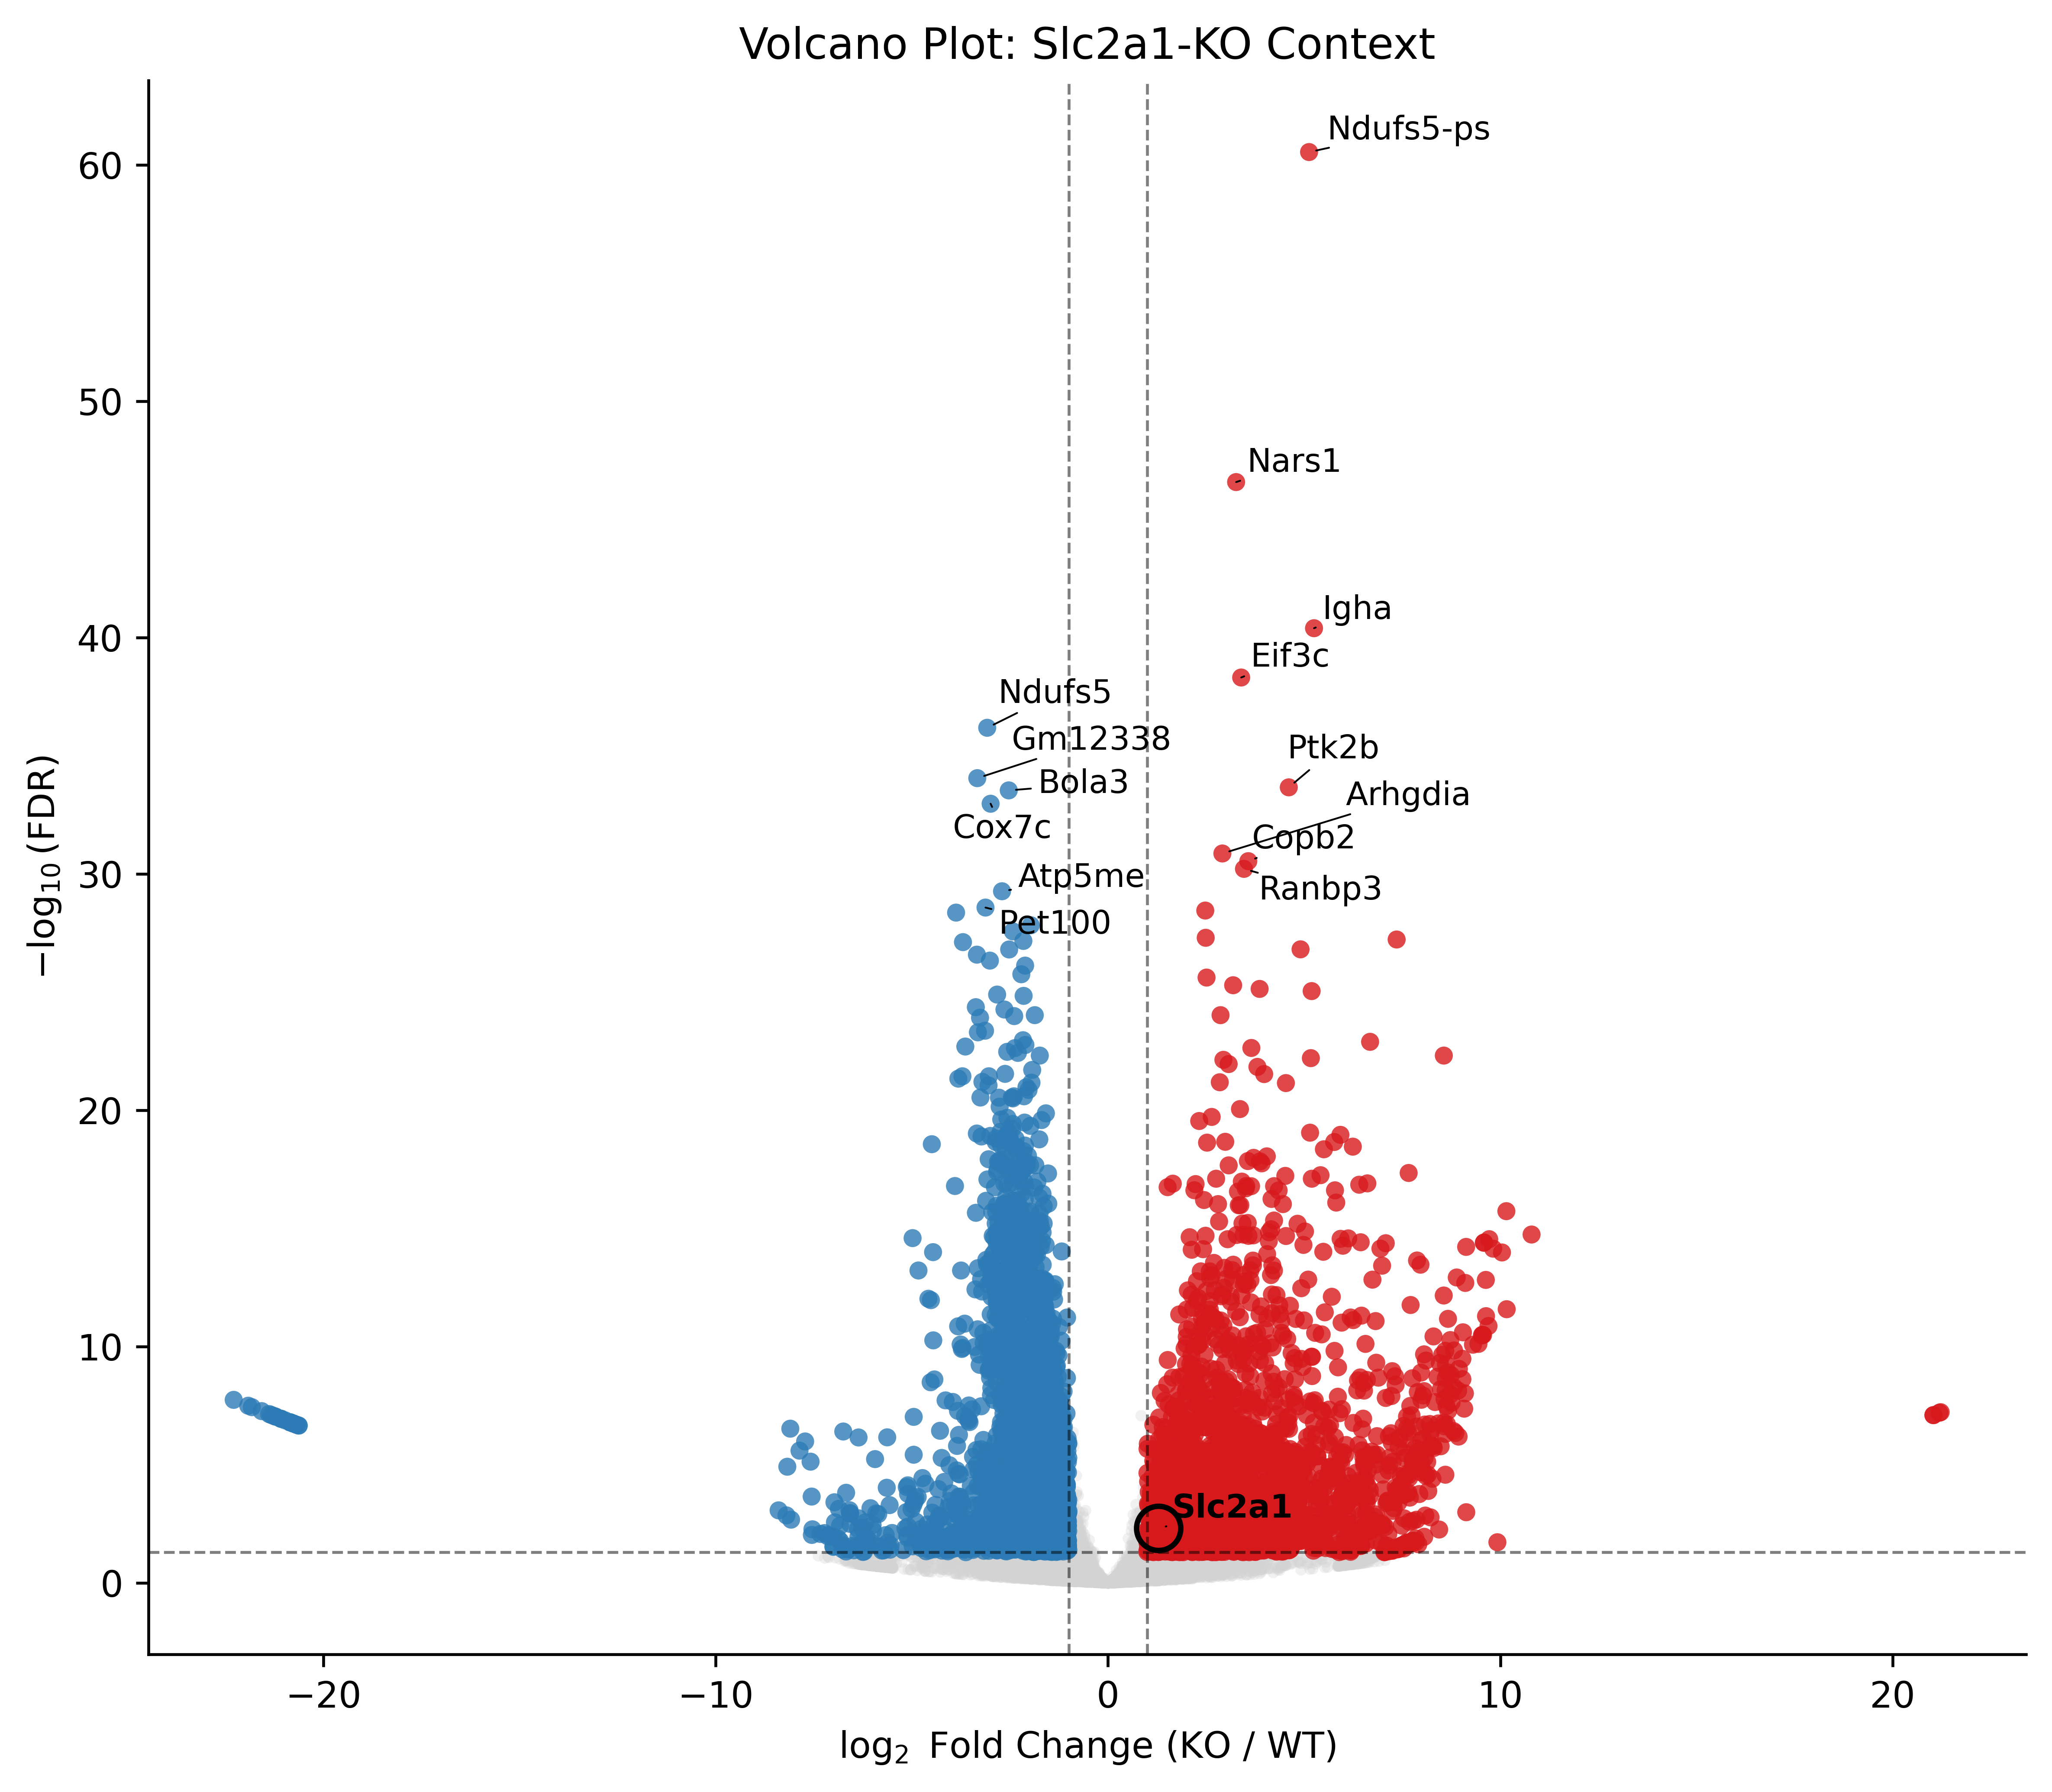

✅ Volcano plot guardado exitosamente.


In [ ]:
# ================== VOLCANO PLOT ==================
from adjustText import adjust_text
import matplotlib.patches as mpatches
import seaborn as sns

# --- CONFIGURACIÓN LOCAL ---
TARGET_GENE = "Slc2a1"  

# 1. Preparar datos locales
vol = df.copy()

# Recalcular significancia localmente (por seguridad) o usar la que ya viene 'sig'
vol["is_sig"] = (vol["padj"] < PADJ_THR) & (vol["log2FoldChange"].abs() >= LFC_THR)

# Filtro de genes "Rik" (genes lncRNA/desconocidos que ensucian el plot)
print(f"Genes antes del filtro Rik: {len(vol)}")
vol = vol[~vol["label"].str.contains(r"Rik$", case=False, regex=True, na=False)].copy()
print(f"Genes después del filtro Rik: {len(vol)}")

# 2. Definición de Colores Semánticos
vol["color"] = "lightgrey" 
vol.loc[(vol["padj"] < PADJ_THR) & (vol["log2FoldChange"] <= -LFC_THR), "color"] = "#2c7bb6" # Azul (Down)
vol.loc[(vol["padj"] < PADJ_THR) & (vol["log2FoldChange"] >= LFC_THR), "color"] = "#d7191c"  # Rojo (Up)

# Subsets para plotear en capas
ns = vol[vol["color"] == "lightgrey"]
sig_down = vol[vol["color"] == "#2c7bb6"]
sig_up = vol[vol["color"] == "#d7191c"]

# 3. Creación de la Figura
fig, ax = plt.subplots(figsize=(8, 7), dpi=DPI)

# Capas de puntos
ax.scatter(ns["log2FoldChange"], ns["neglog10_padj"], c=ns["color"], s=10, alpha=0.3, rasterized=True, linewidth=0)
ax.scatter(sig_down["log2FoldChange"], sig_down["neglog10_padj"], c=sig_down["color"], s=25, alpha=0.8, linewidth=0)
ax.scatter(sig_up["log2FoldChange"], sig_up["neglog10_padj"], c=sig_up["color"], s=25, alpha=0.8, linewidth=0)

# Líneas de corte
ax.axvline(LFC_THR, linestyle="--", color="black", linewidth=0.8, alpha=0.5)
ax.axvline(-LFC_THR, linestyle="--", color="black", linewidth=0.8, alpha=0.5)
ax.axhline(-np.log10(PADJ_THR), linestyle="--", color="black", linewidth=0.8, alpha=0.5)

# 4. ETIQUETADO INTELIGENTE
texts = []
genes_to_label = []

# A) Top genes estadísticos (Más significativos)
top_stats = vol[vol["is_sig"]].sort_values("padj").head(TOP_LABELS)
genes_to_label.extend(top_stats["Gene_stable_ID"].tolist())

# B) Validación del Knockout (Target: Slc2a1)
ko_hit = vol[vol["label"].str.contains(f"^{TARGET_GENE}$", case=False, regex=True, na=False)]

if not ko_hit.empty:
    ko_gene_id = ko_hit.iloc[0]["Gene_stable_ID"]
    ko_lfc = ko_hit.iloc[0]["log2FoldChange"]

    if ko_gene_id not in genes_to_label:
        genes_to_label.append(ko_gene_id)
    
    print(f"VALIDACIÓN KO ({TARGET_GENE}): LFC = {ko_lfc:.4f}")
    
    # Círculo vacío para destacar el KO visualmente
    ax.scatter(
        ko_hit["log2FoldChange"], 
        ko_hit["neglog10_padj"], 
        s=150, 
        facecolors='none', 
        edgecolors='black', 
        linewidth=1.5, 
        zorder=10
    )
else:
    print(f"ADVERTENCIA: No se encontró '{TARGET_GENE}' en los datos.")

# C) Generar textos
labels_to_plot = vol[vol["Gene_stable_ID"].isin(genes_to_label)]

for _, r in labels_to_plot.iterrows():
    weight = "bold" if TARGET_GENE.lower() in str(r["label"]).lower() else "normal"
    texts.append(
        ax.text(r["log2FoldChange"], r["neglog10_padj"], r["label"], fontsize=9, weight=weight)
    )

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Decoración final
ax.set_xlabel(r"$\log_2$ Fold Change (KO / WT)")
ax.set_ylabel(r"$-\log_{10}(\text{FDR})$")
ax.set_title(f"Volcano Plot: {TARGET_GENE}-KO Context")
sns.despine()
plt.tight_layout()
plt.show()

save_png(fig, os.path.join(OUTDIR, "DE_volcano.png"))

In [10]:
# ================== 6) DIAGNÓSTICO DE EMERGENCIA (VALIDACIÓN DEL SIGNO) ==================
# Objetivo: Confirmar si el Knockout realmente tiene menos expresión y si el signo LFC es correcto.

target = "Slc2a1"  # Gen crítico a revisar

print(f"---DIAGNÓSTICO DE: {target} ---")

# 1. Buscar gen en la tabla maestra 'df'
# Usamos regex para coincidencia exacta del nombre
target_row = df[df["label"].str.contains(f"^{target}$", case=False, na=False)]

if target_row.empty:
    print(f"ERROR CRÍTICO: No encuentro '{target}' en los resultados.")
else:
    # Extraer datos reportados por DESeq2
    gene_id = target_row.iloc[0]["Gene_stable_ID"]
    lfc_val = target_row.iloc[0]["log2FoldChange"]
    
    print(f"   ID Ensembl: {gene_id}")
    print(f"   LFC (DESeq2): {lfc_val:.4f} (Signo actual)")

    # 2. CALCULAR EXPRESIÓN REAL (VST)
    # Extraer fila de la matriz VST original
    vst_row = vst[vst["Gene_stable_ID"] == gene_id]
    
    if vst_row.empty:
        print("Error: El ID existe en DE pero no en VST (inconsistencia de datos).")
    else:
        # Extraer valores numéricos y limpiar índice
        # vst tiene columnas de muestras + Gene_stable_ID. Quitamos el ID.
        counts = vst_row.drop(columns=["Gene_stable_ID"]).iloc[0]
        # Convertir a numérico por si acaso
        counts = pd.to_numeric(counts, errors='coerce')
        
        # 3. AGRUPAR POR CONDICIÓN
        # Aseguramos que meta esté indexado por SampleName para mapear
        if "SampleName" in meta.columns:
            meta_map = meta.set_index("SampleName")["Condition"]
        else:
            # Si ya estaba indexado (caso raro en tu flujo actual)
            meta_map = meta["Condition"]
            
        print("\n--- Promedios de Expresión VST (Normalizada) ---")
        means = {}
        
        # Iterar sobre las condiciones reales que existen en los metadatos
        for cond in meta_map.unique():
            # Buscar muestras de esta condición
            samples_cond = meta_map[meta_map == cond].index
            
            # Intersección: Muestras que están en la condición Y en la matriz VST
            valid_samples = [s for s in samples_cond if s in counts.index]
            
            if valid_samples:
                mean_val = counts[valid_samples].mean()
                means[cond] = mean_val
                print(f"   {cond}: {mean_val:.2f} (n={len(valid_samples)})")
            else:
                print(f"   {cond}: Sin muestras coincidentes en VST")

        # 4. VEREDICTO AUTOMÁTICO
        # Intentamos detectar quién es quién
        wt_key = next((k for k in means if any(x in k.upper() for x in ["WT", "CONTROL", "WILD"])), None)
        ko_key = next((k for k in means if any(x in k.upper() for x in ["KO", "MUT", "KNOCK", "HO"])), None)

        if wt_key and ko_key:
            wt_val = means[wt_key]
            ko_val = means[ko_key]
            
            print(f"\n--- CONCLUSIÓN ---")
            print(f"   Comparación: {wt_key} ({wt_val:.2f}) vs {ko_key} ({ko_val:.2f})")
            
            diff = ko_val - wt_val # Diferencia real de expresión
            
            if wt_val > ko_val:
                print("   BIOLOGÍA CORRECTA: El WT expresa más que el KO.")
                print("      (El Knockout funcionó biológicamente)")
                
                # Chequeo de signo LFC
                if lfc_val < 0:
                     print("SIGNO CORRECTO: El LFC es negativo (Indica bajada).")
                else:
                     print("   ALERTA DE SIGNO: El LFC es positivo pero la expresión bajó.")
                     print("      -> DESeq2 calculó WT/KO en lugar de KO/WT.")
                     print("      -> Debes invertir el signo o cambiar el factor level.")
            else:
                print("   ALERTA BIOLÓGICA: El KO expresa MÁS o IGUAL que el WT.")
        else:
            print("\n   No pude detectar automáticamente grupos WT/KO para concluir.")

---DIAGNÓSTICO DE: Slc2a1 ---
   ID Ensembl: ENSMUSG00000028645
   LFC (DESeq2): 1.2929 (Signo actual)

--- Promedios de Expresión VST (Normalizada) ---
   Wild-type: 8.31 (n=4)
   Knockout: 9.61 (n=3)

--- CONCLUSIÓN ---
   Comparación: Wild-type (8.31) vs Knockout (9.61)
   ALERTA BIOLÓGICA: El KO expresa MÁS o IGUAL que el WT.


Genes encontrados: 6 / 6


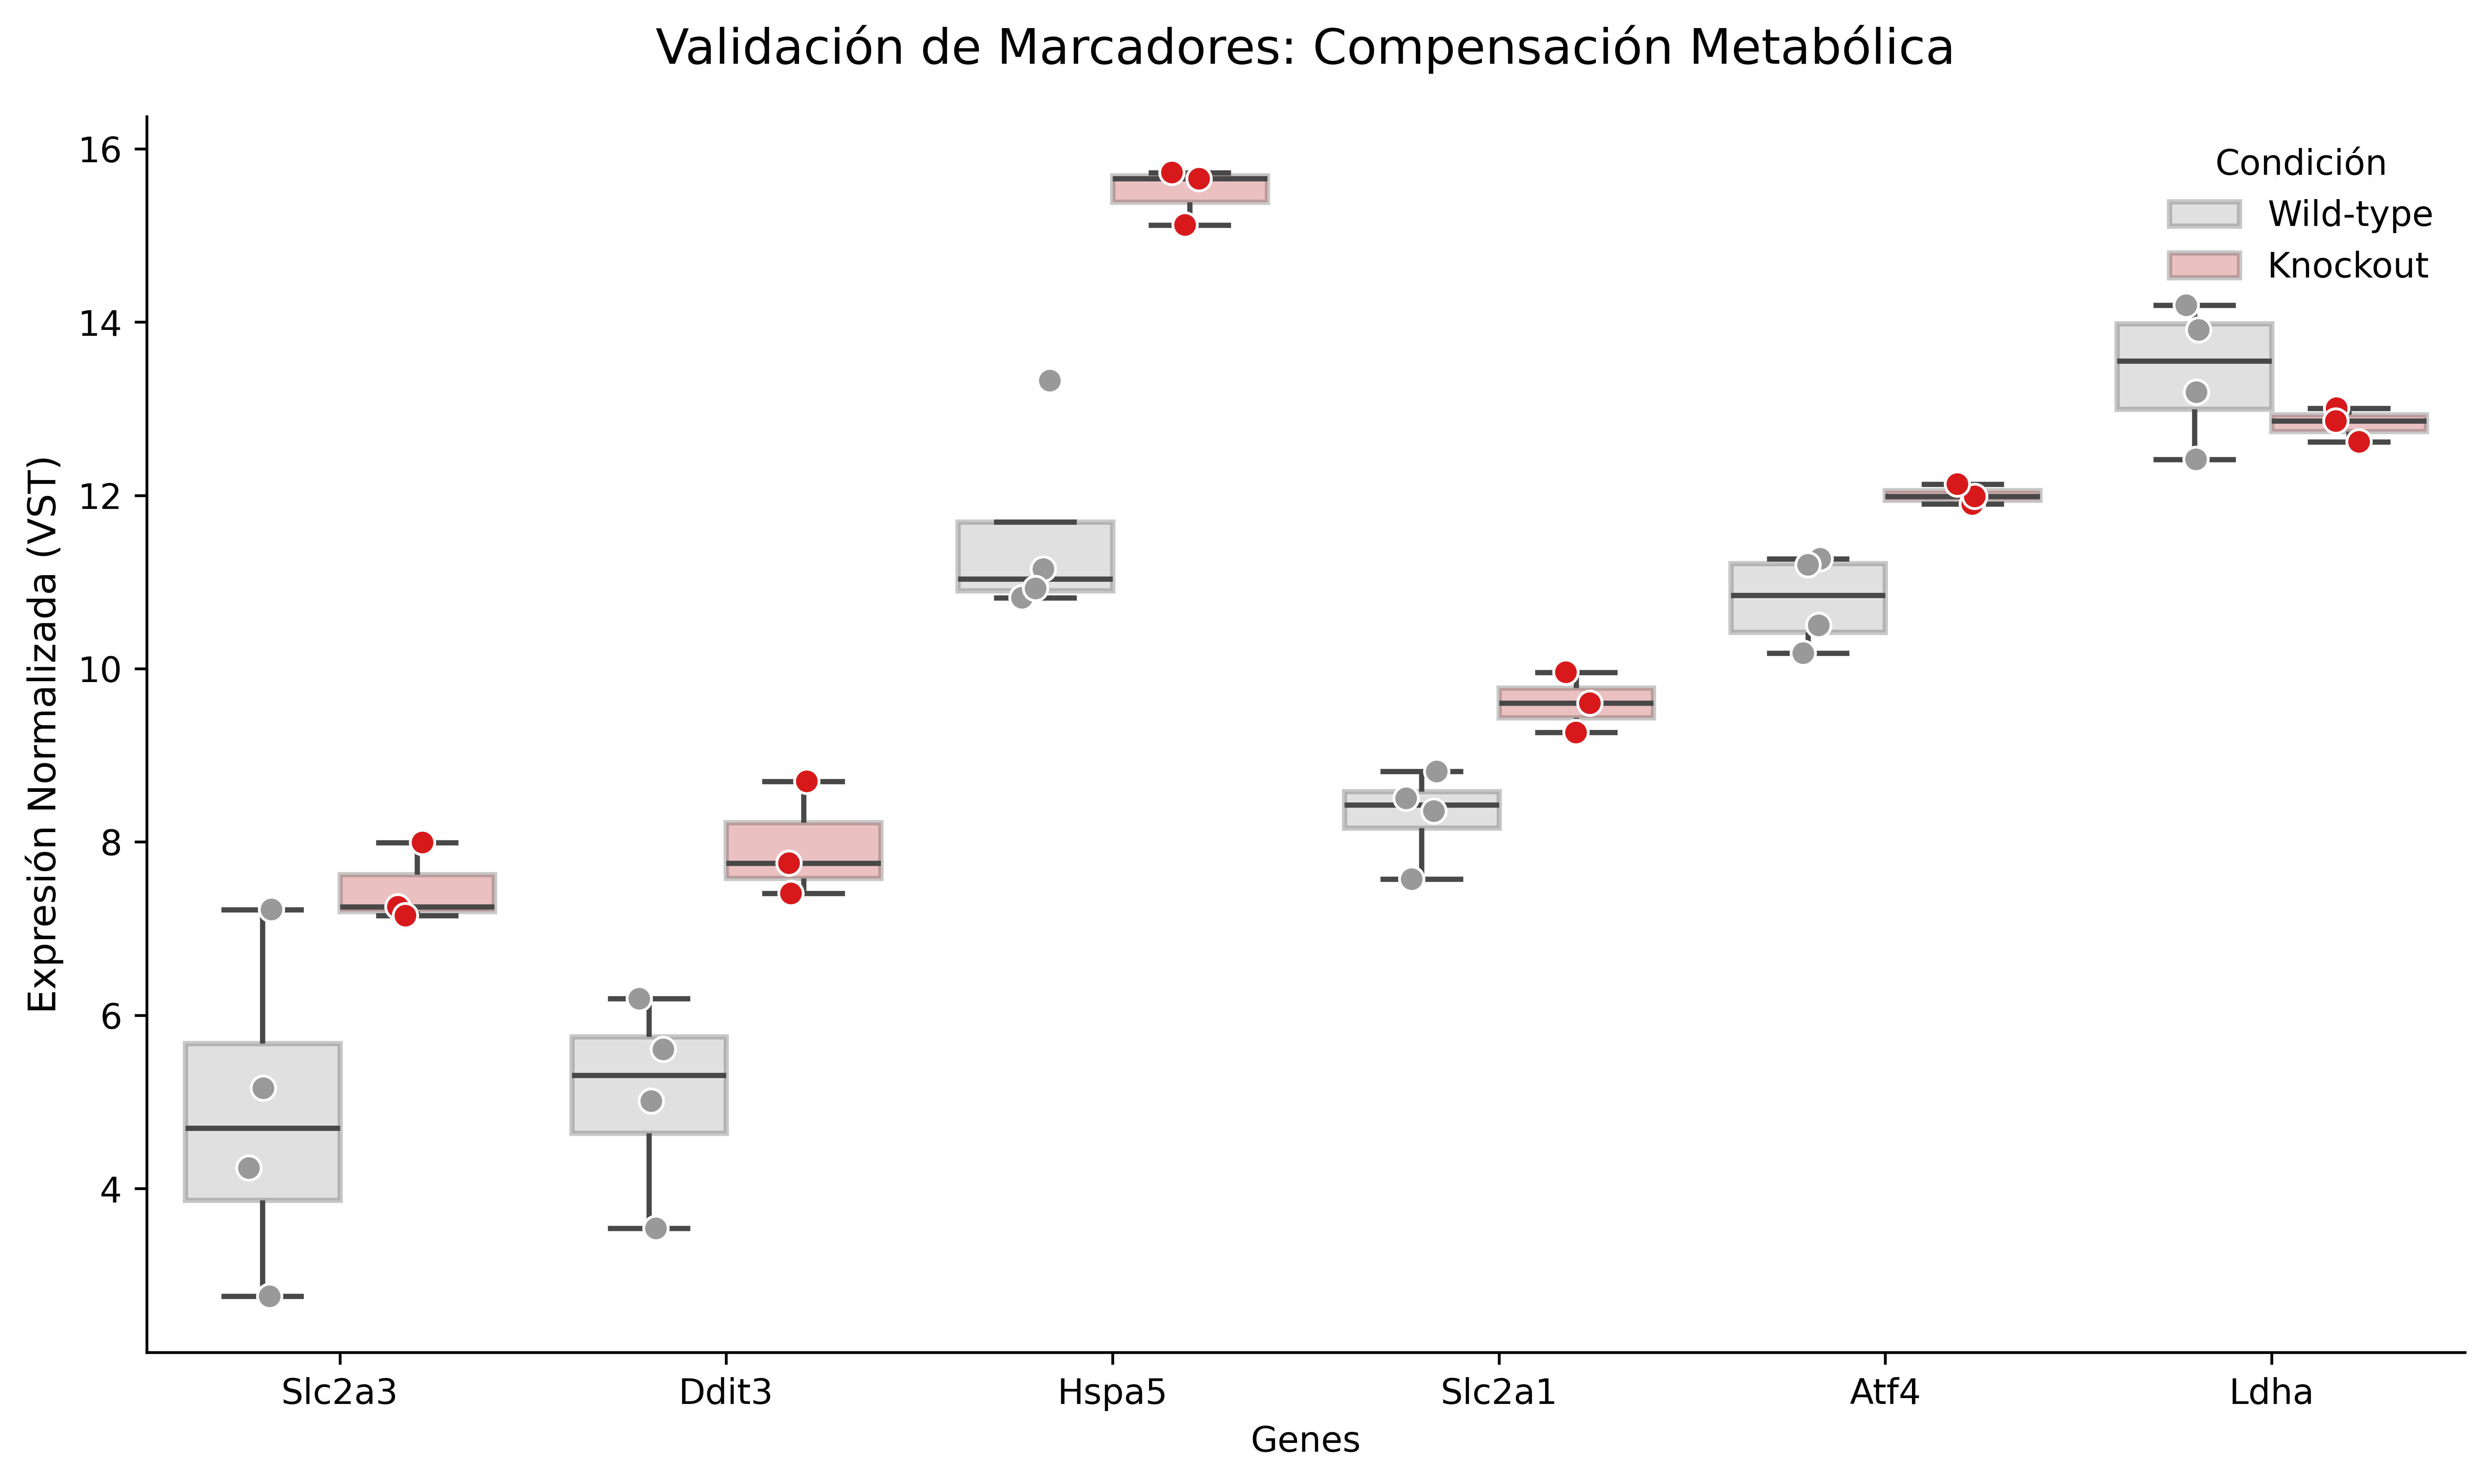

In [7]:
# === VALIDACIÓN DE MARCADORES ===
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. CONFIGURACIÓN
genes_of_interest = ["Slc2a1", "Ldha", "Atf4", "Ddit3", "Hspa5", "Slc2a3"]

# 2. EXTRACCIÓN DE DATOS (VECTORIZADA)
# A) Identificar IDs de los genes buscados (Case insensitive)
target_map = {g.upper(): g for g in genes_of_interest}

# Filtramos df buscando coincidencia
mask = df["label"].str.upper().isin(target_map.keys())
gene_info = df.loc[mask, ["Gene_stable_ID", "label"]].copy()

# Diccionario ID -> Nombre para el gráfico
id_to_name = dict(zip(gene_info["Gene_stable_ID"], gene_info["label"]))

if gene_info.empty:
    print("ERROR: Ninguno de los genes de interés fue encontrado en los resultados.")
else:
    found_genes = gene_info["label"].tolist()
    missing = set(genes_of_interest) - set([g.capitalize() for g in found_genes]) # Aprox
    print(f"Genes encontrados: {len(found_genes)} / {len(genes_of_interest)}")
    if missing: print(f"No encontrados: {missing}")

    # B) Preparar matriz de expresión
    # Filtramos la matriz VST solo con los IDs encontrados
    valid_ids = gene_info["Gene_stable_ID"].unique()
    
    # Aseguramos que vst tenga el ID como índice o columna
    vst_local = vst.copy()
    if "Gene_stable_ID" in vst_local.columns:
        vst_local = vst_local.set_index("Gene_stable_ID")
    
    # Subconjunto y Transposición (Samples x Genes)
    expr_matrix = vst_local.loc[valid_ids].T
    
    # Renombrar columnas de ID a Nombre del Gen
    expr_matrix.columns = [id_to_name.get(x, x) for x in expr_matrix.columns]
    
    # C) Unir con Metadatos (Samples x Genes + Condition)
    # meta tiene SampleName y Condition. Alineamos.
    if "SampleName" in meta.columns:
        meta_indexed = meta.set_index("SampleName")
    else:
        meta_indexed = meta
        
    merged = expr_matrix.join(meta_indexed[["Condition"]], how="inner")
    
    # D) "Derretir" (Melt) para formato largo de Seaborn
    plot_df = merged.melt(id_vars="Condition", var_name="Gene", value_name="Expression")

    # 3. GRAFICAR
    fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

    # Definir paleta (Rojo=KO, Gris=WT)
    unique_conds = plot_df["Condition"].unique()
    my_palette = {}
    for cond in unique_conds:
        if any(x in cond.upper() for x in ["KO", "KNOCK", "MUT"]):
            my_palette[cond] = "#d7191c"  # Rojo
        else:
            my_palette[cond] = "#999999"  # Gris

    # Capa 1: Boxplot (Transparente para ver distribución)
    sns.boxplot(
        data=plot_df, 
        x="Gene", 
        y="Expression", 
        hue="Condition", 
        palette=my_palette, 
        showfliers=False,      # Ocultar outliers (ya mostramos los puntos)
        boxprops=dict(alpha=0.3),
        linewidth=1.5,
        ax=ax
    )

    # Capa 2: Stripplot (Puntos individuales)
    sns.stripplot(
        data=plot_df, 
        x="Gene", 
        y="Expression", 
        hue="Condition", 
        palette=my_palette, 
        dodge=True,            # CRÍTICO: Alinea los puntos con las cajas divididas
        size=7, 
        jitter=True, 
        edgecolor="white",     # Borde blanco para nitidez
        linewidth=0.8,
        legend=False,          # Evita duplicar la leyenda
        ax=ax
    )

    # Estética
    ax.set_title("Validación de Marcadores: Compensación Metabólica", fontsize=14, pad=15)
    ax.set_ylabel("Expresión Normalizada (VST)", fontsize=11)
    ax.set_xlabel("Genes")
    
    # Limpiar leyenda (Seaborn a veces duplica)
    handles, labels = ax.get_legend_handles_labels()
    # Tomamos solo la mitad de los handles porque boxplot genera unos y stripplot otros
    n_conds = len(unique_conds)
    ax.legend(handles[:n_conds], labels[:n_conds], title="Condición", frameon=False)
    
    sns.despine() # Quita bordes derecho y superior
    
    plt.tight_layout()
    plt.show()
    save_png(fig, os.path.join(OUTDIR, "Validation_Markers_Boxplot.png"))

In [8]:
# Bloque para buscar los symbols de los genes para graficos
genes_a_buscar = ["ddit3"]
patron = '|'.join(genes_a_buscar)

resultados = df[df["gene_name"].str.contains(patron, case=False, na=False, regex=True)]

print(resultados[["Gene_stable_ID", "gene_name", "log2FoldChange"]].to_string())

          Gene_stable_ID gene_name  log2FoldChange
5023  ENSMUSG00000025408     Ddit3        3.099688


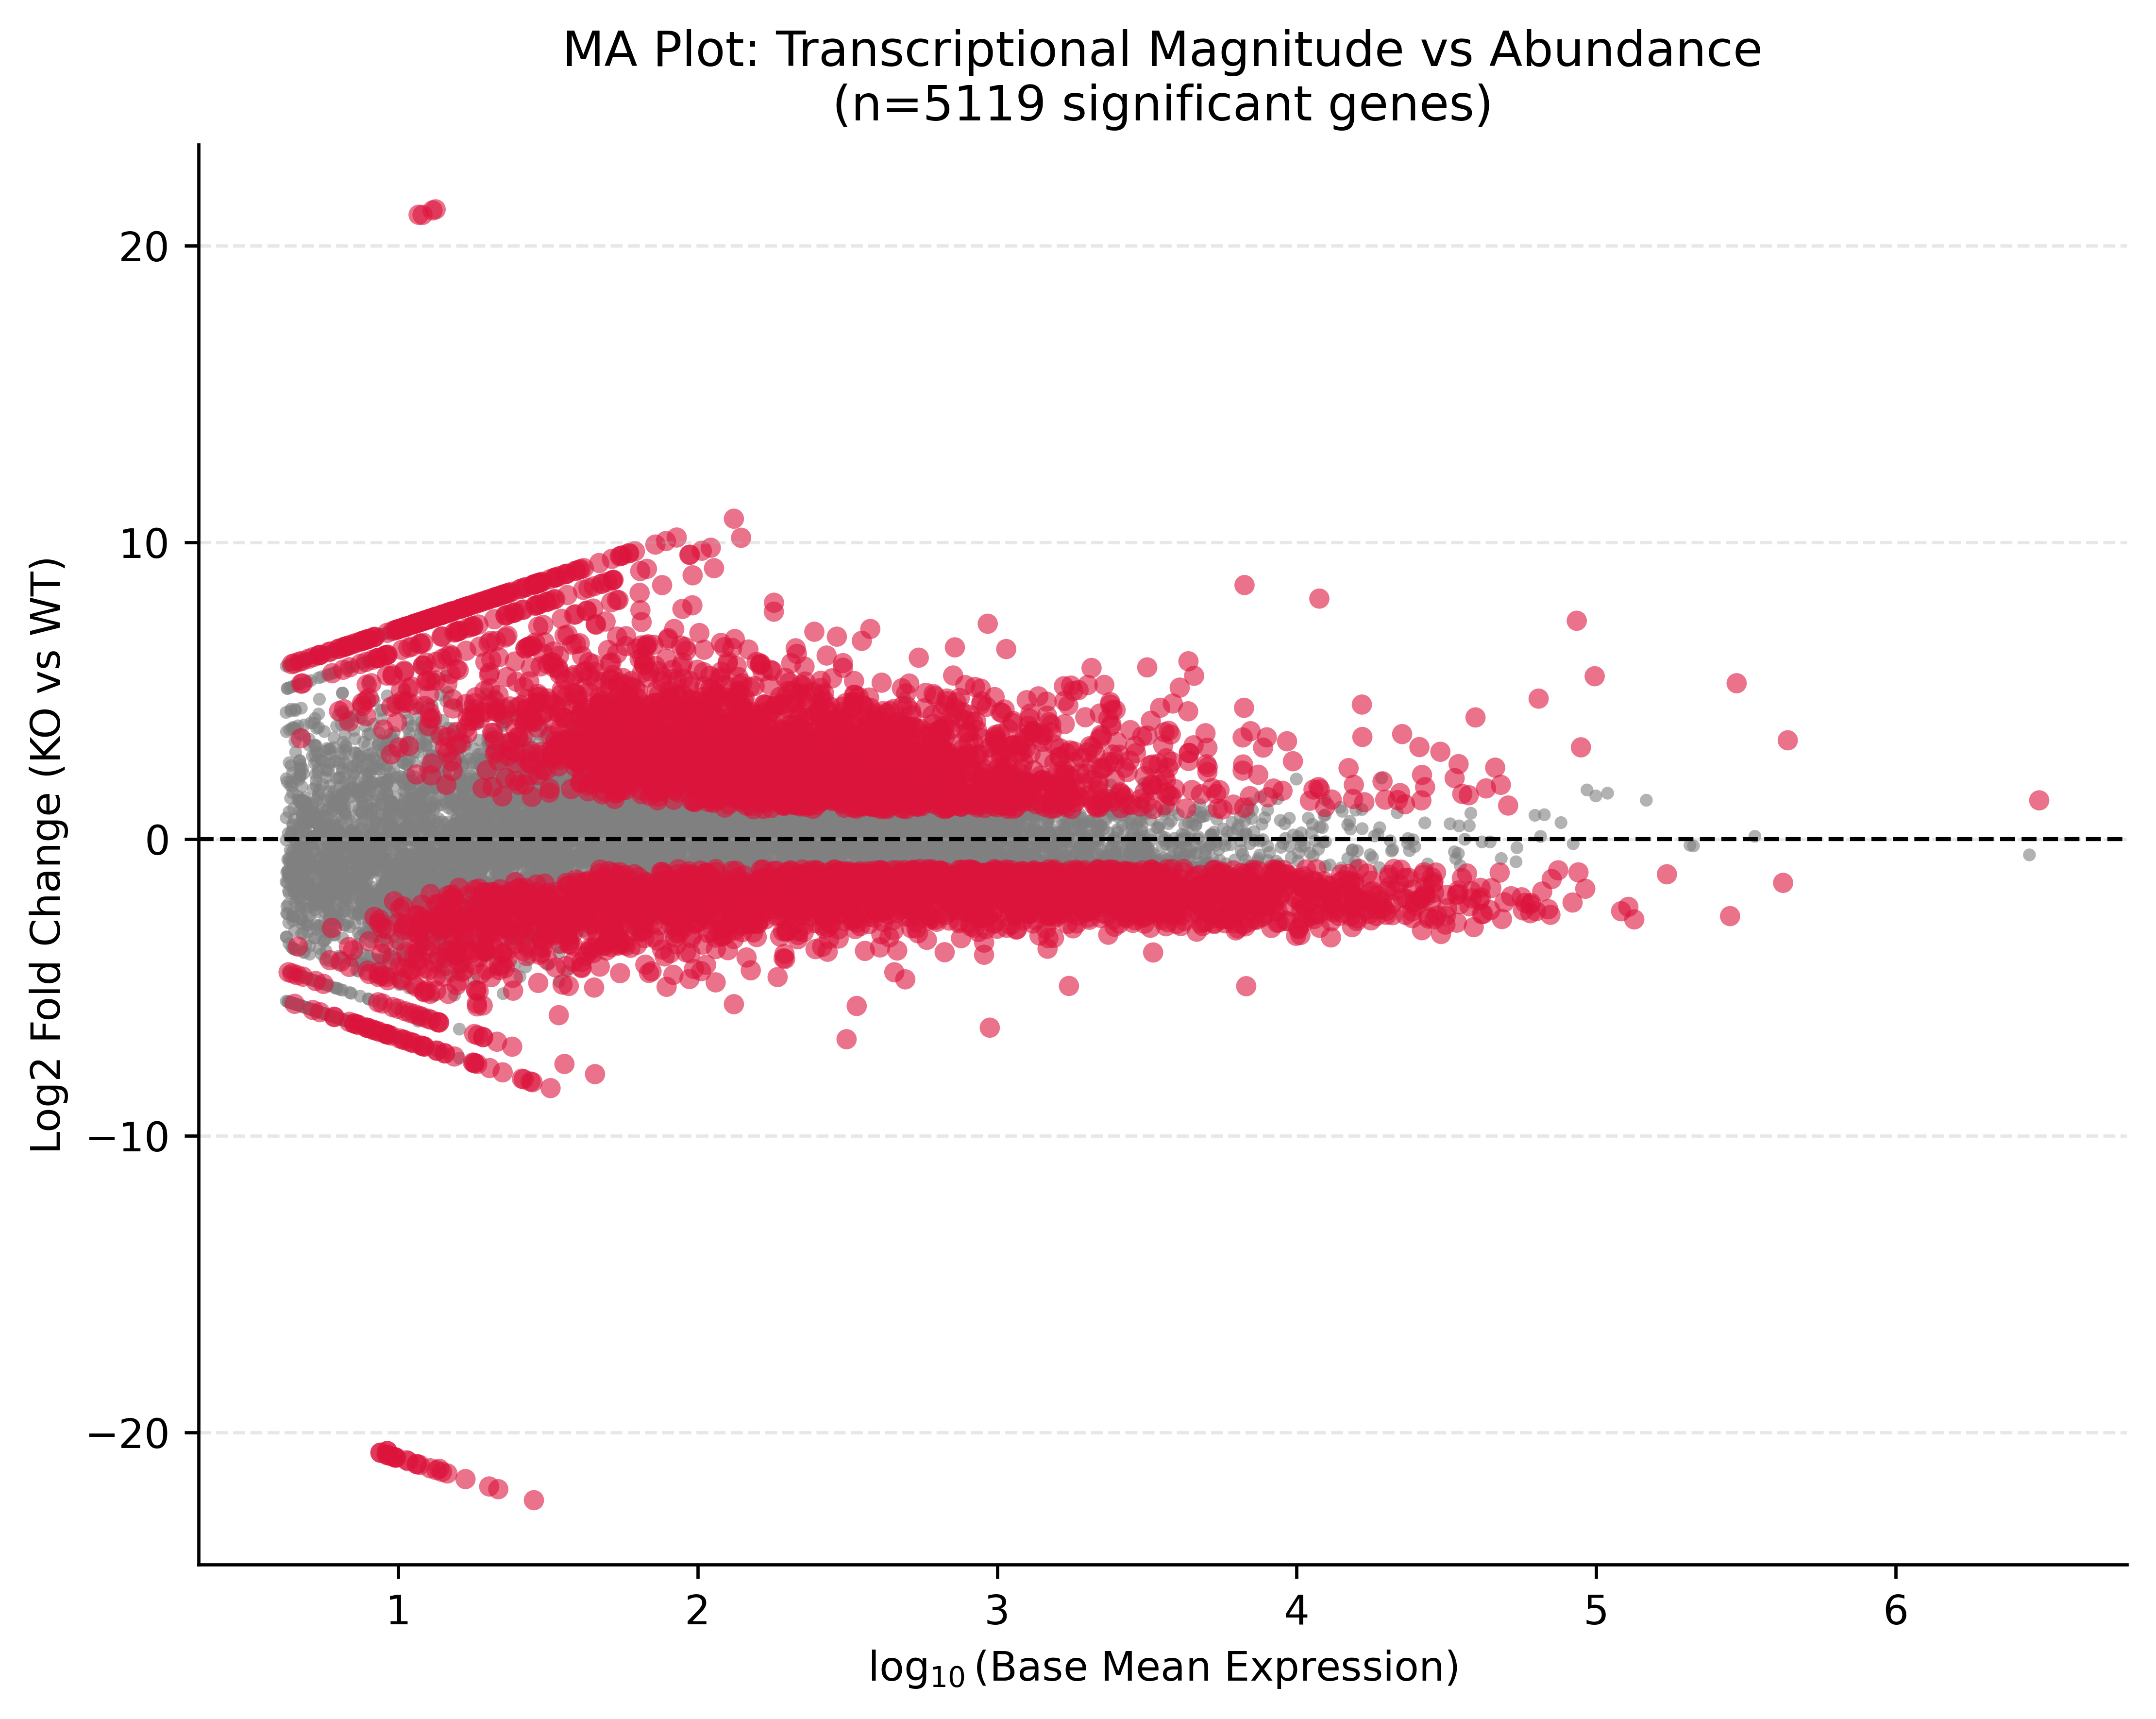

In [ ]:
# ==== MA PLOT ====
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Preparación de Datos
# Usamos 'df' del bloque de carga anterior.
# Detectamos columna de media (baseMean es el estándar de DESeq2)
base_col = next((c for c in ["baseMean", "mean", "AveExpr"] if c in df.columns), None)

if not base_col:
    raise ValueError(f"No encuentro columna de 'baseMean'. Tienes: {df.columns.tolist()}")

# Creamos copia para no afectar el df original
ma = df.dropna(subset=[base_col, "log2FoldChange", "sig"]).copy()

# Calcular eje X (Log10) recortando ceros para evitar errores matemáticos (-inf)
ma["log10_baseMean"] = np.log10(ma[base_col].clip(lower=1e-1))

# 2. TRUCO VISUAL CRÍTICO
# Ordenamos por significancia (False primero, True después).
# Esto obliga a Python a dibujar los puntos rojos ENCIMA de los grises.
ma = ma.sort_values("sig", ascending=True)

# 3. Graficar con Seaborn
fig, ax = plt.subplots(figsize=(7.5, 6), dpi=DPI)

sns.scatterplot(
    data=ma,
    x="log10_baseMean",
    y="log2FoldChange",
    hue="sig",              # Usa la columna 'sig' que creamos en el bloque LOAD
    palette={False: "grey", True: "crimson"},
    style="sig",
    markers={False: "o", True: "o"},
    size="sig",             # Puntos significativos un poco más grandes
    sizes={False: 10, True: 25},
    alpha=0.6,
    linewidth=0,
    legend=False,           # Leyenda desactivada (el color explica todo)
    ax=ax,
    rasterized=True         # Optimización: rasteriza los puntos para que el PDF/SVG no pese 100MB
)

# 4. Decoración
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel(r"$\log_{10}(\text{Base Mean Expression})$")
ax.set_ylabel(f"Log2 Fold Change (KO vs WT)")

# Título dinámico con conteo
sig_count = ma["sig"].sum()
ax.set_title(f"MA Plot: Transcriptional Magnitude vs Abundance\n(n={sig_count} significant genes)")

# Estética limpia
sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Guardar usando el helper
save_png(fig, os.path.join(OUTDIR, "DE_MAplot.png"))

--- Generando PCA 3D ---
   Genes seleccionados por varianza: 2000


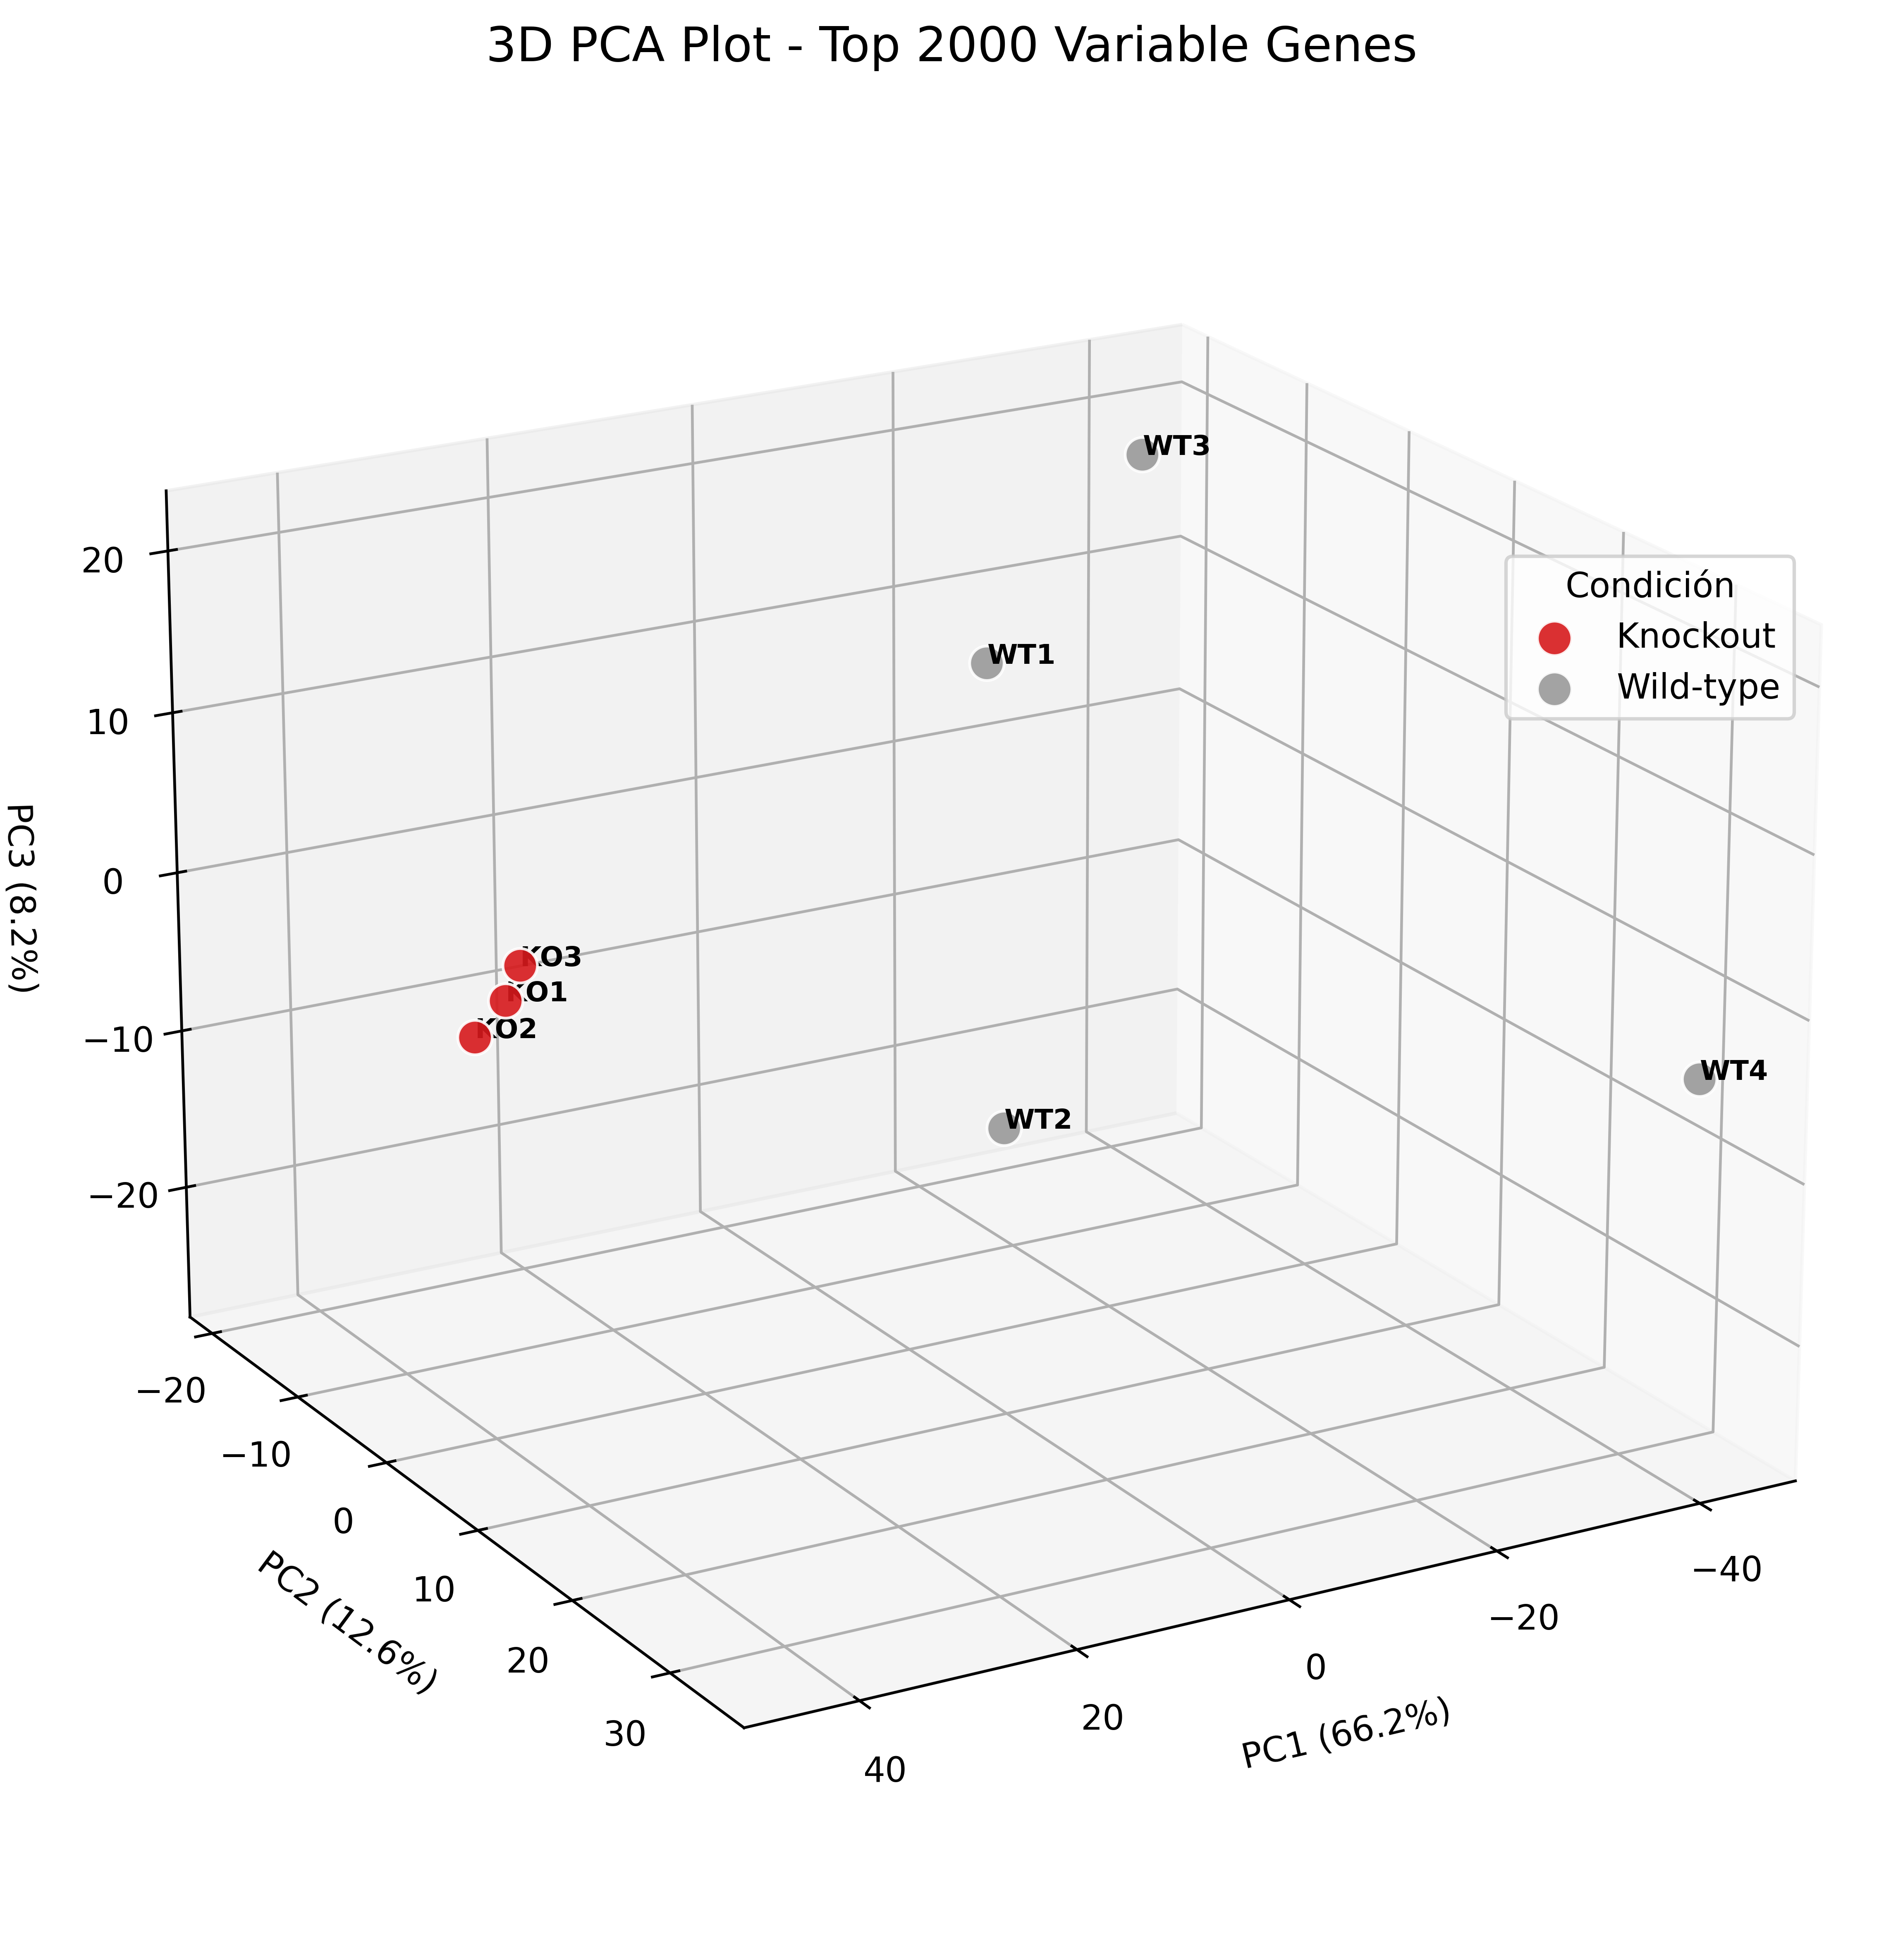

In [23]:
# ==== PCA plot ====
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

print("--- Generando PCA 3D ---")

# 1. FILTRADO DE RUIDO (Top Varianza)
# Usamos 'vst' que cargaste en el bloque LOAD.
# Aseguramos que el ID sea el índice para quedarnos solo con números
if "Gene_stable_ID" in vst.columns:
    vst_numeric = vst.set_index("Gene_stable_ID")
else:
    vst_numeric = vst.set_index("gene_id")

# Calcular varianza y elegir los Top N genes
# .nlargest es mucho más rápido y legible que argsort manual
top_genes = vst_numeric.var(axis=1).nlargest(TOP_PCA_VAR).index
vst_filtered = vst_numeric.loc[top_genes]

print(f"   Genes seleccionados por varianza: {len(vst_filtered)}")

# 2. CÁLCULO DE PCA
# Transponer: Sklearn necesita (Muestras x Genes)
X = vst_filtered.T 

# Escalar (Z-score por columna/gen)
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=3, random_state=42)
coords = pca.fit_transform(X_scaled)
var_exp = pca.explained_variance_ratio_ * 100

# DataFrame de resultados
pca_df = pd.DataFrame(coords, columns=["PC1", "PC2", "PC3"], index=X.index)
# Unir con metadata para tener la columna 'Condition'
# Asumimos que el índice de X son los SampleNames
pca_df = pca_df.merge(meta[["SampleName", "Condition"]], left_index=True, right_on="SampleName")

# 3. GRAFICAR
fig = plt.figure(figsize=(10, 8), dpi=DPI)
ax = fig.add_subplot(111, projection="3d")

# Definir colores automáticamente
unique_conds = pca_df["Condition"].unique()
paleta = {}
for cond in unique_conds:
    # Detectar variantes de KO/Mutant
    if any(x in cond.upper() for x in ["KO", "KNOCK", "MUT"]):
        paleta[cond] = "#d7191c"  
    else:
        paleta[cond] = "#999999" 

# Plotear por grupos
for cond, sub in pca_df.groupby("Condition"):
    ax.scatter(
        sub["PC1"], sub["PC2"], sub["PC3"], 
        s=100, 
        alpha=0.9, 
        label=cond, 
        c=paleta[cond], 
        edgecolors="white", 
        linewidth=0.8
    )
    
    # Etiquetas de texto
    for _, r in sub.iterrows():
        ax.text(r["PC1"], r["PC2"], r["PC3"], r["SampleName"], fontsize=8, weight="bold")

# Etiquetas de Ejes
ax.set_xlabel(f"\nPC1 ({var_exp[0]:.1f}%)")
ax.set_ylabel(f"\nPC2 ({var_exp[1]:.1f}%)")
ax.set_zlabel(f"\nPC3 ({var_exp[2]:.1f}%)")
ax.set_title(f"3D PCA Plot - Top {TOP_PCA_VAR} Variable Genes", fontsize=14)

# Leyenda y Vista
ax.legend(frameon=True, loc="center left", bbox_to_anchor=(0.79, 0.7), title="Condición")
ax.view_init(elev=20, azim=60) # Ángulo óptimo para ver separación

# Guardar
plt.tight_layout()
plt.show()
save_png(fig, os.path.join(OUTDIR, "DE_PCA.png"))

In [6]:
# ================== HEATMAP DE VÍAS METABÓLICAS (CON CLASIFICACIÓN) ==================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

print("--- Preparando matriz de datos... ---")
vst_clean = vst.copy()

if "gene_id" in vst_clean.columns: 
    vst_clean = vst_clean.set_index("gene_id")
elif "Gene_stable_ID" in vst_clean.columns:
    vst_clean = vst_clean.set_index("Gene_stable_ID")

vst_clean.columns = [str(c).strip().strip('"') for c in vst_clean.columns]

meta_clean = meta.copy()
if "SampleName" in meta_clean.columns:
    meta_clean = meta_clean.set_index("SampleName")
meta_clean.index = meta_clean.index.astype(str).str.strip().str.strip('"')

# Intersección de muestras
valid_samples = sorted(list(set(vst_clean.columns).intersection(set(meta_clean.index))))
mat_final = vst_clean[valid_samples]       # <--- AQUÍ SE DEFINE LA VARIABLE QUE FALTABA
meta_final = meta_clean.loc[valid_samples]

# --- 1. CONFIGURACIÓN: DICCIONARIO DE VÍAS ---

pathway_dict = {
    "Glicólisis / Gluconeogénesis": [
        "Slc2a1", "Hk1", "Hk2", "Gpi", "Pfkm", "Aldoa", "Gapdh", 
        "Pgk1", "Pgam1", "Eno1", "Pkm", "Ldha"
    ],
    "Ciclo de Krebs (TCA)": [
        "Cs", "Aco2", "Idh3a", "Ogdh", "Sdha", "Fh", "Mdh2", "Pcx"
    ],
    "Respuesta a Hipoxia (HIF-1)": [
        "Hif1a", "Vegfa", "Egln1", "Bnip3", "Pdk1", "Slc16a3"
    ],
    "Vía Pentosa Fosfato": [
        "G6pd", "Pgd", "Taldo1", "Tkt"
    ]
}

print("--- Procesando genes por vía metabólica ---")

# --- 2. EXTRACCIÓN Y MAPEO ---
selected_ids = []
gene_pathway_map = {}
found_genes_count = 0

for pathway, gene_list in pathway_dict.items():
    for gene in gene_list:
        match = df[df["label"].str.contains(f"^{gene}$", case=False, na=False)]
        if not match.empty:
            gid = match.iloc[0]["Gene_stable_ID"]
        
            if gid in mat_final.index:
                selected_ids.append(gid)
                gene_pathway_map[gid] = pathway 
                found_genes_count += 1
            else:
                pass 
        else:
            print(f"Gen no encontrado en anotación: {gene}")

# Eliminar duplicados manteniendo orden
selected_ids = list(dict.fromkeys(selected_ids))

if len(selected_ids) < 2:
    raise ValueError("No se encontraron suficientes genes para hacer el mapa. " \
    "                  Revisa los nombres.")

print(f"Total genes encontrados para graficar: {len(selected_ids)}")

# --- 3. PREPARAR DATOS Y COLORES ---
# Extraer datos
pathway_data = mat_final.loc[selected_ids]

# Mapear IDs a Nombres para el gráfico
id_to_name = dict(zip(df["Gene_stable_ID"], df["label"]))
pathway_data.index = [id_to_name.get(idx, idx) for idx in pathway_data.index]

# Crear Colores para las Vías (Eje Y - Filas)
# Asignamos un color único a cada vía
pathway_names = list(pathway_dict.keys())
pathway_pal = sns.color_palette("Set2", len(pathway_names))
pathway_lut = dict(zip(pathway_names, pathway_pal))

# Crear vector de colores para las filas
# Nota: gene_pathway_map usa IDs, necesitamos mapear al orden actual del dataframe
row_colors = pd.Series(
    [gene_pathway_map[gid] for gid in selected_ids], 
    index=pathway_data.index
).map(pathway_lut)

# Crear Colores para las Condiciones (Eje X - Columnas)
cond_pal = sns.color_palette("rocket", len(meta_final["Condition"].unique()))
cond_lut = dict(zip(meta_final["Condition"].unique(), cond_pal))
col_colors = meta_final["Condition"].map(cond_lut)

# --- 4. GENERAR CLUSTERMAP ---
g = sns.clustermap(
    pathway_data,
    method="average",
    metric="correlation",    # Agrupa por patrón de subida/bajada similar
    z_score=0,               # Estandarizar por fila
    cmap="vlag",             # Azul-Blanco-Rojo
    center=0,
    
    # Aquí está la magia: Colores laterales
    row_colors=row_colors,
    col_colors=col_colors,
    
    # No clusterizamos filas para mantener el orden de las vías visualmente
    # O SI clusterizamos, los colores nos dirán a qué pertenecen
    row_cluster=True,        
    col_cluster=True,
    
    figsize=(12, 14),        # Ancho, Alto
    dendrogram_ratio=(.1, .15),
    cbar_pos=(0.02, 0.85, 0.02, 0.12),
    yticklabels=True,
    xticklabels=True
)

# --- 5. AJUSTES ESTÉTICOS ---
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    rotation=45, 
    ha="right", 
    fontsize=10, 
    weight="bold")
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)

# Título
g.ax_col_dendrogram.set_title("Expresión Diferencial por Vía Metabólica", fontsize=14)

# --- 6. LEYENDAS PERSONALIZADAS ---
# Leyenda de Condiciones
cond_handles = [Patch(facecolor=cond_lut[name], label=name) for name in cond_lut]
l1 = plt.legend(handles=cond_handles, title="Condición", bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Leyenda de Vías Metabólicas (Agregamos una segunda leyenda)
path_handles = [Patch(facecolor=pathway_lut[name], label=name) for name in pathway_lut]
plt.legend(
    handles=path_handles, 
    title="Vía Metabólica", 
    bbox_to_anchor=(1, 0.95), 
    bbox_transform=plt.gcf().transFigure, 
    loc='upper right')

# Añadir la primera leyenda de vuelta
plt.gca().add_artist(l1)

save_png(g.fig, os.path.join(OUTDIR, "Metabolic_Pathways_Heatmap.png"))
print("Heatmap metabólico generado.")
plt.show()

--- Preparando matriz de datos... ---
--- Procesando genes por vía metabólica ---
Gen no encontrado en anotación: Gpi
Gen no encontrado en anotación: Fh
Gen no encontrado en anotación: G6pd
Total genes encontrados para graficar: 27
Heatmap metabólico generado.


Enriquecimiento funcional

In [11]:
import os
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================== CONFIGURACIÓN ==================
FILES = {
    "GO_BP":    "/home/gonza/bioinfotest/run/progeno_final/diffexp/DAVID_goterm_bp.csv",
    "KEGG": "/home/gonza/bioinfotest/run/progeno_final/diffexp/DAVID_kegg_pathway.csv",
    "MF_GO":    "/home/gonza/bioinfotest/run/progeno_final/diffexp/DAVID_goterm_mf.csv",
}

OUTDIR = "/home/gonza/bioinfotest/run/progeno_final/figures"
os.makedirs(OUTDIR, exist_ok=True)

TOP_N = 15           # Top vías a mostrar
PADJ_THR = 0.05      # Umbral de significancia (FDR/Benjamini)
DPI = 600

# ================== FUNCIONES ==================

def load_and_process(path):
    """Carga, limpia y calcula métricas del archivo DAVID."""
    try:
        df = pd.read_csv(path)
        df.columns = [c.strip() for c in df.columns] # Limpiar espacios en nombres de col
        
        # Detectar columna de P-value ajustado
        pval_col = "Benjamini" if "Benjamini" in df.columns else "FDR"
        
        # Filtrar y limpiar
        df = df[df[pval_col] < PADJ_THR].copy()
        df["neglog10_padj"] = -np.log10(df[pval_col].clip(lower=1e-300))
        
        # Limpiar nombres de términos (quitar ID raro de DAVID tipo "GO:000123~Proceso")
        df["Term_Clean"] = df["Term"].apply(lambda x: x.split("~")[1] if "~" in x else x)
        df["Term_Wrapped"] = df["Term_Clean"].apply(lambda x: "\n".join(textwrap.wrap(x, 40)))
        
        
        # Ordenar por significancia
        df = df.sort_values(pval_col).head(TOP_N)
        return df, pval_col
        
    except Exception as e:
        print(f"Error procesando {path}: {e}")
        return None, None

def plot_enrichment(df, pval_col, title, filename):
    """Genera un DotPlot estilo Seaborn (Bubble Plot)."""
    plt.figure(figsize=(8, 0.4 * len(df) + 2), dpi=DPI)
    
    # Gráfico de puntos
    sns.scatterplot(
        data=df, 
        x="neglog10_padj", 
        y="Term_Wrapped",
        size="Count", 
        hue="neglog10_padj",
        sizes=(100, 600), 
        palette="viridis", 
        legend="brief",
        edgecolor="black",
        linewidth=0.5
    )
    
    # Estética
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel(f"-log10({pval_col})", fontsize=12)
    plt.ylabel("")
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    
    # Mover leyenda afuera
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.close()

def extract_genes_for_heatmap(df, pathway_name):
    """
    Extrae los genes de la vía especificada para usarlos en el heatmap.
    Asume que DAVID tiene una columna 'Genes' separada por comas.
    """
    if "Genes" not in df.columns:
        return "Columna 'Genes' no encontrada en archivo DAVID."
    
    # Busca la fila del pathway
    row = df[df["Term_Clean"] == pathway_name]
    if row.empty:
        return []
    
    # Extrae string de genes, divide y limpia
    genes_str = row.iloc[0]["Genes"]
    # DAVID suele dar formato "ID, ID, ID". Limpiamos y hacemos lista.
    genes_list = [g.strip().upper() for g in genes_str.split(",")]
    return genes_list

print("--- Iniciando Análisis de Enriquecimiento ---")

pathways_for_heatmap = {}

for category, filepath in FILES.items():
    print(f"Procesando {category}...")
    df, pval_col = load_and_process(filepath)
    
    if df is not None and not df.empty:
        # 1. Generar Gráfico
        out_png = os.path.join(OUTDIR, f"Enrichment_{category}.png")
        plot_enrichment(df, pval_col, f"Top {TOP_N} {category} Enrichment", out_png)
        print(f"  Gráfico guardado: {out_png}")
        
        # 2. EXTRAER GENES PARA TU HEATMAP ANTERIOR
        # Tomamos la vía #1 más significativa automáticamente
        top_pathway = df.iloc[0]["Term_Clean"]
        top_genes = extract_genes_for_heatmap(df, top_pathway)
        
        pathways_for_heatmap[f"Top {category}: {top_pathway}"] = top_genes
        
        print(f"  Vía Top detectada: {top_pathway}")
        print(f"  Genes asociados ({len(top_genes)}): {top_genes[:5]}... ")

--- Iniciando Análisis de Enriquecimiento ---
Procesando GO_BP...
  Gráfico guardado: /home/gonza/bioinfotest/run/progeno_final/figures/Enrichment_GO_BP.png
  Vía Top detectada: translation
  Genes asociados (1): ['4.07%']... 
Procesando KEGG...
  Gráfico guardado: /home/gonza/bioinfotest/run/progeno_final/figures/Enrichment_KEGG.png
  Vía Top detectada: Ribosome
  Genes asociados (1): ['2.92%']... 
Procesando MF_GO...
  Gráfico guardado: /home/gonza/bioinfotest/run/progeno_final/figures/Enrichment_MF_GO.png
  Vía Top detectada: structural constituent of ribosome
  Genes asociados (1): ['2.77%']... 
